Recover csv data

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle, Polygon, Patch
%matplotlib inline

import cv2

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from shapely.wkt import loads
from shapely.affinity import scale
from shapely.geometry import mapping, MultiPolygon
import fiona

In [4]:
import sys
sys.path.append("../common/")

In [5]:
from data_utils import get_scalers, LABELS
from image_utils import get_image_data

In [6]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [33]:
CSV_FILE = "../results/sub_unet_3D_mixdeconv_th_80_3_P_M_A_20170228_1143_0.905520990643798.csv"
# CSV_FILE = "../results/sub_unet_3D_mix_th_80_3_P_M_A_20170218_2057_0.8906966279736366_reduced.csv"


Save each image result as SHP

In [8]:
# f_in = open(CSV_FILE)
# print f_in.readline()
# f_in.close()

In [9]:
def _process(line):
    data = line.split(',', 2)
    data[2] = data[2].replace("\"","")
    data[2] = data[2].replace("\n","")
    return data

def submission_iterator(csv_file):
    f_in = open(csv_file)
    _ = f_in.readline()
        
    data_csv = []
    next_data_csv = []
    
    while True:
        
        # First line
        if len(next_data_csv) == 0:
            line =  f_in.readline()
            #print "First line: ", line[:35], len(data_csv), len(next_data_csv)
            if len(line) == 0:
                return
            prev_image_id = image_id = line[:8]
            data_csv.append(_process(line))
        else:            
            data_csv = []
            data_csv.append(next_data_csv)
            # print "Copy next_data_csv -> data_csv", next_data_csv[:2], data_csv[0][:2]
            prev_image_id = image_id = next_data_csv[0]
            next_data_csv = []
            
            
        # Loop
        counter = 0
        while counter < 15:
            prev_image_id = image_id
            line = f_in.readline()
            if len(line) == 0:
                return 
            image_id = line[:8]
            if image_id == prev_image_id:
                data_csv.append(_process(line))
                prev_image_id = image_id
            else:                
                next_data_csv = _process(line)
                # print "End of unique ImageId : ", len(data_csv), "Next is", next_data_csv[0], next_data_csv[1]
                yield data_csv
                break

In [10]:
def write_shp_from_csv(filename, data_csv, simplify=False, tol=5, n_pts=15):
    # Write a new Shapefile
    image_id = data_csv[0][0]
    h, w, _ = get_image_data(image_id, '3b', return_shape_only=True)
    xs, ys = get_scalers(image_id, h, w)
    
    all_scaled_polygons = {}
    for poly_info in data_csv: 
        if "MULTIPOLYGON" not in poly_info[2][:20]:
            continue
        polygons = loads(poly_info[2]) 
        scaled_polygons = scale(polygons, xfact=xs, yfact=-ys, origin=(0, 0, 0)) 
        all_scaled_polygons[int(poly_info[1])] = scaled_polygons
        if simplify:
            for k in scaled_polygons:
                if len(scaled_polygons[k].exterior.coords) > n_pts:
                    scaled_polygons[k] = scaled_polygons[k].simplify(tolerance=5)
    write_shp_from_polygons(filename, image_id, all_scaled_polygons)
    
    
def write_shp_from_polygons(filename, image_id, all_scaled_polygons):
    schema = {
        'geometry': 'MultiPolygon',
        'properties': {'image_id': 'str', 'class': 'int'},
    }
    with fiona.open(filename, 'w', 'ESRI Shapefile', schema) as c:
        for k in all_scaled_polygons:
            polygons = all_scaled_polygons[k]
            # To align with images in QGis
            polygons = scale(polygons, xfact=1.0, yfact=-1.0, origin=(0, 0, 0)) 
            c.write({
                'geometry': mapping(polygons),
                'properties': {'image_id': image_id, 'class': k},
            })
    print "Written succesfully file : ", filename

In [11]:
# n_files_to_process = 10
# count = 0 
# for data_csv in submission_iterator(CSV_FILE):
#     print "--", data_csv[0][0], len(data_csv)
#     write_shp_from_csv("%s.shp" % data_csv[0][0], data_csv)
#     count += 1
#     if count == n_files_to_process:
#         break 

In [12]:
# write_shp('test_simplified.shp', data_csv, simplify=True)

In [13]:
import numpy as np
import cv2
from data_utils import get_scalers


def compute_label_image(image_id, scaled_polygons, image_type='3b'):
    image_shape = get_image_data(image_id, image_type, return_shape_only=True)    
    out = np.zeros((image_shape[0], image_shape[1], len(LABELS)), np.uint8)
    out[:,:,0] = 1
    round_coords = lambda x: np.array(x).round().astype(np.int32)
    for class_type in range(1, len(LABELS)):
        if class_type not in scaled_polygons:
            continue
        one_class_mask = np.zeros((image_shape[0], image_shape[1]), np.uint8)
        for polygon in scaled_polygons[class_type]:
            exterior = [round_coords(polygon.exterior.coords)]
            cv2.fillPoly(one_class_mask, exterior, 1)
            if len(polygon.interiors) > 0:
                interiors = [round_coords(poly.coords) for poly in polygon.interiors]
                cv2.fillPoly(one_class_mask, interiors, 0)
        out[:,:,class_type] = one_class_mask
        out[:,:,0] = np.bitwise_xor(out[:,:,0], np.bitwise_and(out[:,:,0], one_class_mask)) # =x ^ (x & y)
    return out

In [14]:
def get_polygons(data_csv):
    out = {}
    for poly_info in data_csv: 
        if "MULTIPOLYGON" not in poly_info[2][:20]:
            continue
        polygons = loads(poly_info[2]) 
        out[poly_info[1]] = polygons
    return out

def get_scaled_polygons(data_csv, image_type='3b'):
    out = {}
    image_id = data_csv[0][0]
    h, w, _ = get_image_data(image_id, image_type, return_shape_only=True)
    xs, ys = get_scalers(image_id, h, w)
    for poly_info in data_csv: 
        if "MULTIPOLYGON" not in poly_info[2][:20]:
            continue
        polygons = loads(poly_info[2]) 
        scaled_polygons = scale(polygons, xfact=xs, yfact=ys, origin=(0, 0, 0)) 
        out[int(poly_info[1])] = scaled_polygons
    return out

In [15]:
data_iterator = submission_iterator(CSV_FILE)

In [16]:
labels_image = None
image_3b = None
for data_csv in data_iterator:
    print "--", data_csv[0][0], len(data_csv)
    image_id = data_csv[0][0]
    polygons = get_scaled_polygons(data_csv)
    labels_image = compute_label_image(image_id, polygons)
    image_3b = get_image_data(image_id, '3b')
    break

-- 6120_2_4 10


In [17]:
from visu_utils import display_img_1b, display_img_3b, plt_st

In [18]:
from postprocessing_utils import sieve

def crop_postprocessing(bin_img):
    """
    Mask post-processing for 'Crops'
    
    - Enlarge pathes and erode boundaries <-> Morpho Erode
    - Smooth forms <-> Smooth countours with median filter
    - No small fields <-> Remove small detections with sieve, linear size < 100 pixels     
    - No small holes, do not touch pathes <-> Remove small non-detections with sieve, linear size < 50 pixels 
    
    """

    x = cv2.morphologyEx(bin_img, cv2.MORPH_ERODE, kernel=np.ones((3,3), dtype=np.uint8), iterations=2)

    x = cv2.medianBlur(x, ksize=7)
    x = cv2.medianBlur(x, ksize=7)
    x = (x > 0.5).astype(np.uint8)
        
    x = sieve(x, 100)
    h, w = x.shape
    
    inv_x = (x < 0.5).astype(np.uint8)
    inv_x = inv_x[1:h, 1:w]
    inv_x = sieve(inv_x, 75)   
    x[1:h, 1:w] = (inv_x < 0.5).astype(np.uint8)    
    
    x[0:5,:] = bin_img[0:5,:]
    x[:,0:5] = bin_img[:,0:5]
    x[-6:,:] = bin_img[-6:,:]
    x[:,-6:] = bin_img[:,-6:]
    return x


# def trees_postprocessing(bin_img):
#     """
#     Mask post-processing for 'Trees'
    
#     - Smooth forms <-> Smooth countours with median filter
#     - No small holes <-> Remove small non-detections with sieve, linear size < 10 pixels 
    
#     """
#     bin_img = cv2.medianBlur(bin_img, ksize=3)
#     bin_img = (bin_img > 0.55).astype(np.uint8)
    
#     bin_img = (bin_img < 0.5).astype(np.uint8)
#     h, w = bin_img.shape
#     bin_img[1:h-1, 1:w-1] = sieve(bin_img[1:h-1, 1:w-1], 10)   
#     bin_img = (bin_img < 0.5).astype(np.uint8)    
        
#     return bin_img


def path_postprocessing(bin_img):
    """
    Mask post-processing for 'Path' (label 4)
    
    - Enlarge pathes <-> Morpho close
    - Smooth forms <-> Smooth countours with median filter    
    """
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_DILATE, kernel=np.ones((3,3), dtype=np.uint8), iterations=1)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, kernel=np.ones((3,3), dtype=np.uint8), iterations=2)

    bin_img = cv2.medianBlur(bin_img, ksize=3)
    bin_img = (bin_img > 0.55).astype(np.uint8)
    
    #lines = cv2.HoughLinesP()
                
    return bin_img

In [19]:
class_pp_func_list = {
    4: path_postprocessing,
    6: crop_postprocessing,
}

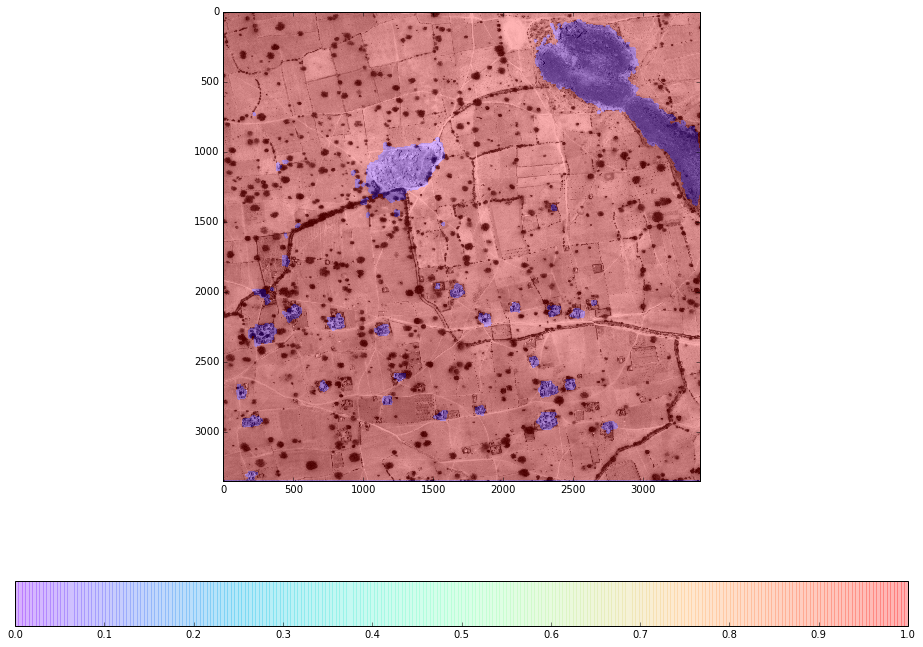

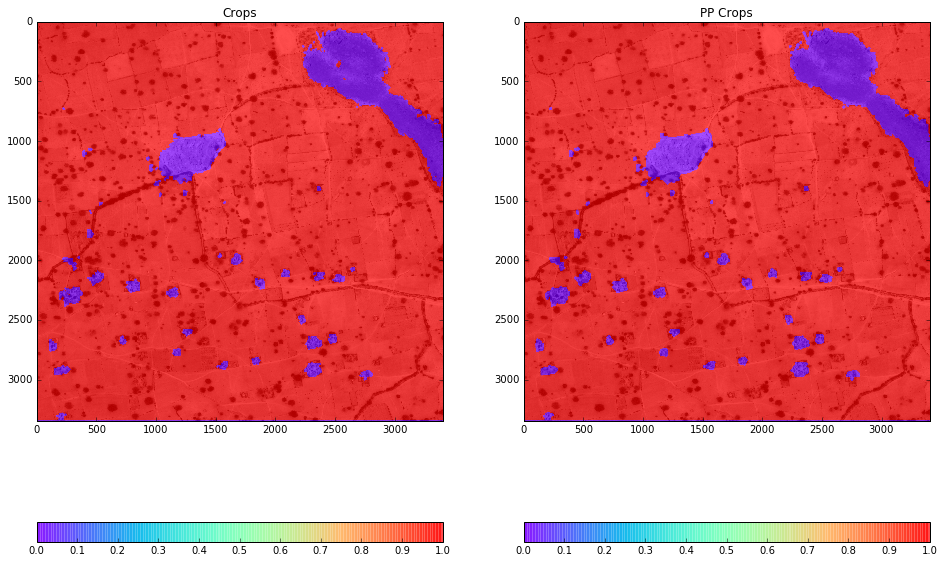

In [20]:
roi = None

# roi = [3000, 0, 3300, 300]
# roi = [0, 1500, 250, 1750]
# roi = [500, 500, 1750, 1750]
# roi = [750, 2750, 1350, 3300]

index = 6
if index in class_pp_func_list:
    bin_img = class_pp_func_list[index](labels_image[:,:,index])
else:
    bin_img = labels_image[:,:,index]

plt_st(16, 12)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(bin_img, roi, alpha=0.3, clim=[0, 1], cmap='rainbow')

plt_st(16, 12)
plt.subplot(121)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(labels_image[:,:,index], roi, alpha=0.7, clim=[0, 1], cmap='rainbow')
plt.title(LABELS[index])
plt.subplot(122)
display_img_1b(image_3b[:,:,0], roi, no_colorbar=True)
display_img_1b(bin_img, roi, alpha=0.7, clim=[0, 1], cmap='rainbow')
plt.title("PP " + LABELS[index])

In [27]:
def mask_postprocessing(labels_image, class_pp_func_list):
    out = np.zeros_like(labels_image)
    for i, l in enumerate(LABELS):
        if i in class_pp_func_list:
            out[:,:,i] = class_pp_func_list[i](labels_image[:,:,i])
        else:
            out[:,:,i] = labels_image[:,:,i]
    return out

In [28]:
from data_utils import mask_to_polygons

def write_shp_from_mask(filename, image_id, labels_image):
    all_scaled_polygons = {}
    for class_index in range(1, len(LABELS[1:])):
        polygons = mask_to_polygons(labels_image[:, :, class_index])
        all_scaled_polygons[class_index] = polygons
    write_shp_from_polygons(filename, image_id, all_scaled_polygons)    

In [465]:
pp_labels_image = mask_postprocessing(labels_image, class_pp_func_list)

In [466]:
write_shp_from_mask("%s_pp.shp" % image_id, image_id, pp_labels_image)

Self-intersection at or near point 2488.7408312958437 2092.7530562347188


Written succesfully file :  6120_2_1_pp.shp


Recover whole CSV

In [46]:
class_pp_func_list = {
    4: path_postprocessing,
    6: crop_postprocessing,
}
# class_pp_func_list = {}

In [22]:
import pandas as pd
from shapely.wkt import dumps
from datetime import datetime

Test CSV size on 20 image ids

In [23]:
# empty_polygon = 'MULTIPOLYGON EMPTY'
# ll = len(LABELS[1:])
# out_df_new = pd.DataFrame(columns=['ImageId', 'ClassType', 'MultipolygonWKT'])
# out_df_old = pd.DataFrame(columns=['ImageId', 'ClassType', 'MultipolygonWKT'])

# data_iterator = submission_iterator(CSV_FILE)
# index = 0
# test_limit = 10
# for data_csv in data_iterator:
#     print "--", data_csv[0][0], len(data_csv), index
#     image_id = data_csv[0][0]
    
#     polygons = get_scaled_polygons(data_csv)
#     labels_image = compute_label_image(image_id, polygons)
#     image_3b = get_image_data(image_id, '3b')
#     pp_labels_image = mask_postprocessing(labels_image, class_pp_func_list)
    
#     x_scaler, y_scaler = get_scalers(image_id, pp_labels_image.shape[0], pp_labels_image.shape[1])
#     for class_index in range(1, len(LABELS[1:])):
        
#         # Write old:
#         out_df_old.loc[ll * index + class_index - 1, :] = [image_id, str(class_index), data_csv[class_index - 1][2]]
        
#         # Write new:
#         polygons = mask_to_polygons(pp_labels_image[:, :, class_index - 1])           
#         if len(polygons) == 0:
#             out_df_new.loc[ll * index + class_index - 1, :] = [image_id, str(class_index), empty_polygon]
#         else:            
#             unit_polygons = scale(polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler, origin=(0, 0, 0))
#             out_df_new.loc[ll * index + class_index - 1, :] = [image_id, str(class_index), dumps(unit_polygons)]
#     index += 1
#     if index == test_limit:
#         break
    
# submission_file_new = '../results/submission_new_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
# out_df_new.to_csv(submission_file_new, index=False)    

# submission_file_old = '../results/submission_old_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
# out_df_old.to_csv(submission_file_old, index=False)    

In [ ]:
# empty_polygon = 'MULTIPOLYGON EMPTY'
# ll = len(LABELS[1:])
# out_df = pd.DataFrame(columns=['ImageId', 'ClassType', 'MultipolygonWKT'])

# data_iterator = submission_iterator(CSV_FILE)
# index = 0
# for data_csv in data_iterator:
#     print "--", data_csv[0][0], len(data_csv), index
#     image_id = data_csv[0][0]
#     polygons = get_scaled_polygons(data_csv)
#     labels_image = compute_label_image(image_id, polygons)
#     image_3b = get_image_data(image_id, '3b')
#     pp_labels_image = mask_postprocessing(labels_image, class_pp_func_list)
    
#     x_scaler, y_scaler = get_scalers(image_id, pp_labels_image.shape[0], pp_labels_image.shape[1])
#     for class_index in range(1, len(LABELS[1:])):
        
#         polygons = mask_to_polygons(pp_labels_image[:, :, class_index - 1])   
        
#         if len(polygons) == 0:
#             out_df.loc[ll * index + class_index - 1, :] = [image_id, str(class_index), empty_polygon]
#         else:            
#             unit_polygons = scale(polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler, origin=(0, 0, 0))
#             out_df.loc[ll * index + class_index - 1, :] = [image_id, str(class_index), dumps(unit_polygons)]
#     index += 1
    
# submission_file = '../results/submission_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
# out_df.to_csv(submission_file, index=False)    

-- 6120_2_4 10 0


Self-intersection at or near point 3229.896907216495 1975.3608247422681
Self-intersection at or near point 3031.6555023923447 1585.1307814992026


-- 6120_2_3 10 1


Self-intersection at or near point 2901.2459396751742 2460.6334106728536
Self-intersection at or near point 832.91017964071852 1266.7964071856288
Self-intersection at or near point 157 1617


-- 6120_2_1 10 2


Self-intersection at or near point 3399.3482142857142 2636.4821428571427
Self-intersection at or near point 2488.7408312958437 2092.7530562347188


-- 6180_2_4 10 3


Self-intersection at or near point 3122.25 1508.6428571428571
Self-intersection at or near point 3259.4683840749412 1885.1334894613583


-- 6180_2_1 10 4


Self-intersection at or near point 3288.8000000000002 74.066666666666663
Self-intersection at or near point 2746 910.38461538461536


-- 6180_2_0 10 5


Self-intersection at or near point 2829.2421383647797 1667.4150943396226
Self-intersection at or near point 2781.7346938775509 2692.1224489795918


-- 6180_2_3 10 6


Self-intersection at or near point 3141.4989154013015 2081.9891540130152
Self-intersection at or near point 2643.8360655737706 2978.8360655737706
Self-intersection at or near point 1007.9894973743436 1625.0097524381094


-- 6180_2_2 10 7


Self-intersection at or near point 3167.0396039603961 1214.9108910891089
Self-intersection at or near point 2414.0357142857142 2307.09375


-- 6180_0_3 10 8


Self-intersection at or near point 3331.0564971751414 1138.7288135593221
Self-intersection at or near point 1127.1941448382127 987.47457627118649


-- 6180_0_2 10 9


Self-intersection at or near point 3336.019342359768 1218.9671179883946
Self-intersection at or near point 3139.647852760736 594.79509202453983


-- 6180_0_1 10 10


Self-intersection at or near point 3059 1060.0333333333333
Self-intersection at or near point 3175.9264705882351 2421.1911764705883


-- 6180_0_0 10 11


Self-intersection at or near point 3371.4285714285716 654
Self-intersection at or near point 2877.0443686006824 143.90784982935153


-- 6180_0_4 10 12


Self-intersection at or near point 3371.100386100386 3269.0077220077219
Self-intersection at or near point 3103.7333333333331 2486.7666666666669


-- 6080_4_4 10 13


Self-intersection at or near point 3334.3174946004319 1903.6522678185745
Self-intersection at or near point 1036.875 1176.25


-- 6080_4_2 10 14


Self-intersection at or near point 3336.7360178970916 1787.3333333333333
Self-intersection at or near point 1058.820788530466 1549.1612903225807
Self-intersection at or near point 2090.2342954159594 2154.3276740237693


-- 6080_4_3 10 15


Self-intersection at or near point 3337.3816254416961 2664.7950530035337
Self-intersection at or near point 70.366265060240963 2172.6963855421686
Self-intersection at or near point 3333.8945386064029 2580.9868173258005


-- 6080_4_0 10 16


Self-intersection at or near point 3337.3741258741261 2447.8111888111889
Self-intersection at or near point 2204.8101265822784 155.52215189873417


-- 6080_4_1 10 17


Self-intersection at or near point 3296.4006309148267 2877.2208201892745
Self-intersection at or near point 2379.0357142857142 816.14285714285711
Self-intersection at or near point 1100.4549125168237 2509.615074024226


-- 6090_4_1 10 18


Self-intersection at or near point 3232.033033033033 1295.9549549549549
Self-intersection at or near point 1050.8648180242635 1773.7920277296359


-- 6090_4_0 10 19


Self-intersection at or near point 3219.8576271186439 897.97627118644073
Self-intersection at or near point 3017.6063122923588 3341.2940199335549


-- 6090_4_3 10 20


Self-intersection at or near point 3214.057706909643 172.95596051632498
Self-intersection at or near point 3200.9559322033897 1032.9864406779661


-- 6090_4_2 10 21


Self-intersection at or near point 3390.9757412398922 1510.4851752021564


-- 6090_4_4 10 22


Self-intersection at or near point 3284.7335701598581 1297.4689165186501
Self-intersection at or near point 1859.1850533807828 2878.2170818505338
Self-intersection at or near point 3283.9787234042551 1296.6808510638298


-- 6180_4_4 10 23


Self-intersection at or near point 2702.6486486486488 142.45945945945945
Self-intersection at or near point 2703.031007751938 142.06201550387595


-- 6180_4_3 10 24


Self-intersection at or near point 2673.2352941176468 1231.0588235294117
Self-intersection at or near point 2327.909090909091 545.36363636363637


-- 6180_4_2 10 25


Self-intersection at or near point 2024.6682926829269 3298.0878048780487
Self-intersection at or near point 2672.0517241379312 15.925287356321839


-- 6180_4_1 10 26


Self-intersection at or near point 3259.1878862793574 1047.0395550061805
Self-intersection at or near point 3219.1627296587926 3282.0656167979005


-- 6180_4_0 10 27


Self-intersection at or near point 3391.4064293915039 1678.0126291618828
Self-intersection at or near point 391.94059405940595 672.25742574257424


-- 6160_3_2 10 28


Self-intersection at or near point 2273.2658227848101 2126.2278481012659
Ring Self-intersection at or near point 153 3219


-- 6160_3_3 10 29


Self-intersection at or near point 3095.8215613382899 1024.3345724907063


-- 6160_3_0 10 30


Self-intersection at or near point 2331.9738562091502 1922.0849673202615
Self-intersection at or near point 1671.6486486486488 458.05405405405406


-- 6160_3_1 10 31


Self-intersection at or near point 3344.818181818182 677.12121212121212
Self-intersection at or near point 2837.8741007194244 862.8830935251799


-- 6160_3_4 10 32


Self-intersection at or near point 3309.2195121951218 2457.6829268292681


-- 6080_2_4 10 33


Self-intersection at or near point 3328.0163934426228 231.40437158469945
Self-intersection at or near point 2143.3157894736842 2342.7368421052633
Self-intersection at or near point 3059 1940.6428571428571


-- 6080_2_0 10 34


Self-intersection at or near point 3335.7014531043592 2228.4095112285336


-- 6080_2_1 10 35


Self-intersection at or near point 3253 628.5


-- 6080_2_2 10 36


Self-intersection at or near point 2819.3582089552237 1067.2388059701493
Self-intersection at or near point 697.243553008596 2944.2148997134673
Self-intersection at or near point 2187.3000000000002 2779.0250000000001


-- 6080_2_3 10 37


Self-intersection at or near point 3299.3825363825363 806.0935550935551
Self-intersection at or near point 1149.1606118546845 2041.5717017208412


-- 6080_0_2 10 38


Self-intersection at or near point 3314.2727272727275 1495.7272727272727
Ring Self-intersection at or near point 128 379
Self-intersection at or near point 272.0972972972973 425.57297297297299


-- 6080_0_3 10 39


Self-intersection at or near point 3335.0004268943435 2349.5240128068303
Self-intersection at or near point 937.96598639455783 2677.0408163265306
Ring Self-intersection at or near point 740 2937
Self-intersection at or near point 2730.029702970297 654.80198019801981


-- 6080_0_0 10 40


Self-intersection at or near point 3275.1771595900441 1178.9092240117129
Self-intersection at or near point 3275.6652360515022 1178.8025751072962
Self-intersection at or near point 2036.9536423841059 2435.1125827814571


-- 6080_0_1 10 41


Self-intersection at or near point 3138.6990595611287 85.695924764890279
Self-intersection at or near point 1507.0786026200874 3061.3668122270742
Self-intersection at or near point 2023.6494845360826 3223.536082474227


-- 6080_0_4 10 42


Self-intersection at or near point 3332.5922330097087 3062.8640776699031
Self-intersection at or near point 2087 1747.25
Self-intersection at or near point 1602.6701030927834 1534.0103092783504
Self-intersection at or near point 1104.4778156996588 2240.1433447098975
Self-intersection at or near point 999.94382022471905 2803.9775280898875


-- 6010_0_4 10 43


Self-intersection at or near point 2658.7293233082705 853.31578947368416
Self-intersection at or near point 262.11344537815125 2733.5840336134452
Self-intersection at or near point 1848.1535974130961 1297.941794664511


-- 6010_0_1 10 44


Self-intersection at or near point 3018.1750000000002 174.86250000000001
Self-intersection at or near point 2943.5371900826444 590.47933884297515


-- 6010_0_0 10 45


Self-intersection at or near point 3304.4252491694351 564.23255813953483
Ring Self-intersection at or near point 347 1337
Self-intersection at or near point 3032.9000000000001 1146.8399999999999


-- 6010_0_3 10 46


Self-intersection at or near point 3259.900900900901 1446.9369369369369
Self-intersection at or near point 721.88834951456306 1842.6747572815534


-- 6010_0_2 10 47


Self-intersection at or near point 3004.4601226993864 1261.8282208588957
Self-intersection at or near point 2459.1626794258373 788.09569377990431


-- 6010_2_3 10 48


Self-intersection at or near point 2138.090909090909 2065
Ring Self-intersection at or near point 564 2893


-- 6010_2_2 10 49


Self-intersection at or near point 736 2329.5333333333333


-- 6010_2_1 10 50


Self-intersection at or near point 2903.7441860465115 2849.9302325581393
Ring Self-intersection at or near point 885 1462


-- 6010_2_0 10 51


Self-intersection at or near point 1789.9868421052631 1916.6052631578948


-- 6010_2_4 10 52


Self-intersection at or near point 3242.1172291296625 1057.4920071047957
Self-intersection at or near point 1639.5894736842106 645.15789473684208


-- 6010_4_1 10 53


Self-intersection at or near point 2685.9849624060153 131.90225563909775
Ring Self-intersection at or near point 2876 3283


-- 6170_3_4 10 54


Self-intersection at or near point 3289 1362.7826086956522
Self-intersection at or near point 217.9795918367347 934.87755102040819


-- 6010_4_3 10 55


Self-intersection at or near point 2663.375 1835
Self-intersection at or near point 1462.7584097859328 1145.0244648318044
Self-intersection at or near point 1358.2258064516129 1113.6774193548388


-- 6170_3_1 10 56


Self-intersection at or near point 3310.910931174089 404.12955465587044
Ring Self-intersection at or near point 2778 1058
Ring Self-intersection at or near point 1410 2802


-- 6170_3_0 10 57


Self-intersection at or near point 3376.7512953367877 1435.6943005181347
Self-intersection at or near point 2778.2972972972975 2227.1216216216217


-- 6170_3_3 10 58


Self-intersection at or near point 3236.3333333333335 1743.3333333333333
Self-intersection at or near point 3186.0563002680965 40.021447721179626


-- 6170_3_2 10 59


Self-intersection at or near point 2700 1976.1428571428571
Self-intersection at or near point 744.88235294117646 16.941176470588236
Self-intersection at or near point 1854.0357142857142 2329.9285714285716


-- 6170_1_3 10 60


Self-intersection at or near point 3353.6896551724139 3282.0344827586205
Self-intersection at or near point 1810 2581.1764705882351


-- 6170_1_2 10 61


Self-intersection at or near point 3377.170616113744 2453.9810426540284
Self-intersection at or near point 3377.0206185567008 2452.1649484536083


-- 6170_1_1 10 62


Self-intersection at or near point 3184.181818181818 2763.3939393939395
Self-intersection at or near point 2703.5454545454545 2617.3636363636365


-- 6170_1_0 10 63


Self-intersection at or near point 3390.323943661972 3020.6619718309857
Self-intersection at or near point 3252.4375 2849


-- 6170_1_4 10 64


Self-intersection at or near point 3291.9756097560976 967.09756097560978
Ring Self-intersection at or near point 642 3140


-- 6130_4_2 10 65


Self-intersection at or near point 3139 1963.1016949152543


-- 6130_4_3 10 66


Self-intersection at or near point 3263.9333333333334 1574.6500000000001
Self-intersection at or near point 2178.7654320987654 1893.9506172839506
Ring Self-intersection at or near point 2235 1730
Self-intersection at or near point 819.93570451436392 2721.3365253077977


-- 6130_4_0 10 67


Self-intersection at or near point 3151.4834710743803 2915.465564738292
Self-intersection at or near point 1089.9890109890109 168.34615384615384


-- 6130_4_1 10 68


Self-intersection at or near point 3257.0183486238534 1498.7614678899083
Self-intersection at or near point 2959.6034482758619 686.48275862068965


-- 6130_4_4 10 69


Self-intersection at or near point 3344.6603585657372 2740.4631474103585
Self-intersection at or near point 2782.4137931034484 724.65517241379314
Self-intersection at or near point 3099.1591836734692 970.25714285714287
Self-intersection at or near point 1960.8766519823789 725.92070484581495


-- 6150_3_3 10 70


Self-intersection at or near point 3359.0506329113923 248.16455696202533
Self-intersection at or near point 3256.7234042553191 459.02127659574467
Ring Self-intersection at or near point 1879 3030


-- 6150_3_2 10 71


Self-intersection at or near point 2339.6405228758172 594.03921568627447
Self-intersection at or near point 2203.1336032388663 939.12145748987859


-- 6150_3_1 10 72


Self-intersection at or near point 3155.7522611089266 2221.567046795124
Self-intersection at or near point 2108.391304347826 1658.6521739130435
Ring Self-intersection at or near point 883 1578


-- 6150_3_0 10 73


Self-intersection at or near point 2063.4166666666665 2580
Self-intersection at or near point 145.13136456211814 3040.7443991853361


-- 6150_3_4 10 74


Self-intersection at or near point 3233.2702702702704 2257.7837837837837


-- 6130_2_0 10 75


Self-intersection at or near point 3220.016129032258 964.9677419354839
Self-intersection at or near point 836.90890269151134 1316.5776397515529


-- 6130_2_1 10 76


Self-intersection at or near point 3273 243.57142857142858
Self-intersection at or near point 1282.2628062360802 1411.2494432071269


-- 6130_2_2 10 77


Self-intersection at or near point 3111 2415
Ring Self-intersection at or near point 110 364


-- 6130_2_3 10 78


Self-intersection at or near point 3386.287081339713 2852.5837320574165


-- 6130_2_4 10 79


Self-intersection at or near point 3180.1136950904393 1926.2635658914728
Self-intersection at or near point 1019 154
Self-intersection at or near point 1604 1654.5


-- 6130_0_4 10 80


Self-intersection at or near point 3004.8047337278108 2850.5088757396452
Self-intersection at or near point 2857.1237113402062 3096.9484536082473


-- 6130_0_2 10 81


Self-intersection at or near point 3391.0756143667295 881.43478260869563
Self-intersection at or near point 401.96699669966995 357.0792079207921
Ring Self-intersection at or near point 1 2069


-- 6130_0_3 10 82


Self-intersection at or near point 2956.0285714285715 1721.8857142857144
Self-intersection at or near point 2254.5965818759937 1312.4725755166933


-- 6130_0_0 10 83


Self-intersection at or near point 3184.9040767386091 1844.5347721822543
Self-intersection at or near point 2767.4601769911505 1017.8053097345132


-- 6130_0_1 10 84


Self-intersection at or near point 3368.1666666666665 3165.3888888888887
Self-intersection at or near point 2779.2327586206898 3302.8943965517242
Self-intersection at or near point 1577.1587743732591 2167.5376044568247


-- 6150_1_4 10 85


Self-intersection at or near point 3228.4407713498622 403.58953168044076
Self-intersection at or near point 801.07936507936506 3188.7142857142858


-- 6150_1_1 10 86


Self-intersection at or near point 3355.8400000000001 870.36000000000001
Self-intersection at or near point 1539.1428571428571 701.42857142857144
Self-intersection at or near point 1668.8341463414633 604.1219512195122
Self-intersection at or near point 2813.0457782299086 32.224313326551375


-- 6150_1_0 10 87


Self-intersection at or near point 3100.7724288840263 2939.5470459518601
Self-intersection at or near point 1802.6315789473683 144.36842105263159


-- 6150_1_3 10 88


Self-intersection at or near point 3259.9259259259261 219
Self-intersection at or near point 2611.9947089947091 1605.94708994709


-- 6150_1_2 10 89


Self-intersection at or near point 1801.9078341013824 919.14746543778801
Ring Self-intersection at or near point 2207 2423


-- 6180_3_4 10 90


Self-intersection at or near point 1174.5169230769231 1570.0984615384616
Self-intersection at or near point 3387.4481327800831 1530.2614107883817


-- 6180_3_0 10 91


Self-intersection at or near point 3140.313915857605 3216.6051779935274
Self-intersection at or near point 3140 3218.6666666666665


-- 6180_3_1 10 92


Self-intersection at or near point 3290.3636363636365 2465.7272727272725
Self-intersection at or near point 2003.2470588235294 43.564705882352939
Self-intersection at or near point 155.27272727272728 1150.5454545454545


-- 6180_3_2 10 93


Self-intersection at or near point 3364.2111368909514 2251.7076566125288
Self-intersection at or near point 3351.4000000000001 947.36000000000001


-- 6180_3_3 10 94


Self-intersection at or near point 3059.0454545454545 560.65909090909088
Self-intersection at or near point 2979.0078125 542.3515625


-- 6180_1_2 10 95


Self-intersection at or near point 3058.8137254901962 2054.2107843137255
Self-intersection at or near point 2958.2285714285713 3286.8857142857141


-- 6180_1_3 10 96


Self-intersection at or near point 3380.5654345654348 2977.6553446553448
Self-intersection at or near point 2648.3333333333335 25.509803921568629


-- 6180_1_0 10 97


Self-intersection at or near point 3250.2727272727275 2870.6363636363635
Self-intersection at or near point 1709.7727272727273 2739.8636363636365


-- 6180_1_1 10 98


Self-intersection at or near point 2740.8382352941176 869.22058823529414
Self-intersection at or near point 2595.6363636363635 480.10909090909092


-- 6180_1_4 10 99


Self-intersection at or near point 3238.2803738317757 37.747663551401871
Self-intersection at or near point 1472.1337209302326 1611.8691860465117


-- 6010_1_4 10 100


Self-intersection at or near point 2736.1908548707752 1423.5089463220677


-- 6010_1_0 10 101


Self-intersection at or near point 1759.828125 220.140625


-- 6010_1_1 10 102


Self-intersection at or near point 1565.1401869158879 843.08411214953276


-- 6010_1_2 10 103


Self-intersection at or near point 1254.9965034965035 884.94755244755243
Ring Self-intersection at or near point 422 2956


-- 6010_1_3 10 104


Self-intersection at or near point 1938 3348
Ring Self-intersection at or near point 1558 2673


-- 6010_3_2 10 105


Self-intersection at or near point 3241.5116279069766 2423.3126614987082
Self-intersection at or near point 1086.1219512195121 1837.0536585365853


-- 6010_3_3 10 106


Self-intersection at or near point 3200.3333333333335 2008.8333333333333
Ring Self-intersection at or near point 2868 1380


-- 6010_3_0 10 107


Self-intersection at or near point 2824.7761194029849 3012.4029850746269
Ring Self-intersection at or near point 2111 2123


-- 6010_3_1 10 108


Self-intersection at or near point 3143.2249999999999 93.171428571428578
Self-intersection at or near point 1227.690036900369 843.29704797047975


-- 6010_3_4 10 109


Self-intersection at or near point 3304.8681818181817 916.85454545454547
Self-intersection at or near point 1692.9591836734694 141.9795918367347


-- 6020_0_4 10 110


Self-intersection at or near point 3260.3730366492146 887.02486910994764
Self-intersection at or near point 2897.878787878788 2023.939393939394


-- 6020_0_0 10 111


Self-intersection at or near point 2769.2352941176468 591.35294117647061


-- 6020_0_1 10 112


Self-intersection at or near point 2940.9966044142616 2301.125636672326
Self-intersection at or near point 724 3242.5


-- 6020_0_2 10 113


Self-intersection at or near point 1738.4225352112676 114.63380281690141
Self-intersection at or near point 567.45783132530119 513.38554216867465
Self-intersection at or near point 1379.5908529048208 214.45859085290482
Ring Self-intersection at or near point 2507 3322


-- 6020_0_3 10 114


Self-intersection at or near point 3282.3333333333335 2491.3333333333335


-- 6020_2_2 10 115


Self-intersection at or near point 2660.909090909091 837.36363636363637
Self-intersection at or near point 1589.1578947368421 1025.8157894736842


-- 6020_2_3 10 116


Self-intersection at or near point 2625.3348554033487 2219.0334855403348


-- 6020_2_0 10 117


Self-intersection at or near point 3266.2629482071711 2428.2788844621514
Self-intersection at or near point 2140.5588235294117 3220.6911764705883
Self-intersection at or near point 113.14516129032258 3146.1532258064517


-- 6020_2_1 10 118


Self-intersection at or near point 3110.8092105263158 1242.5387426900584


-- 6020_2_4 10 119


Self-intersection at or near point 2370.5352112676055 2793.0281690140846
Self-intersection at or near point 1839 1109
Self-intersection at or near point 3144.0223463687153 1772.193668528864


-- 6020_4_0 10 120


Self-intersection at or near point 1438.4285714285713 374.71428571428572
Ring Self-intersection at or near point 2218 2613


-- 6020_4_1 10 121


Self-intersection at or near point 2744.1730769230771 2591.7692307692309
Ring Self-intersection at or near point 1852 754


-- 6020_4_2 10 122


Self-intersection at or near point 2893 769.79999999999995


-- 6020_4_3 10 123


Self-intersection at or near point 2967.711724137931 1.9696551724137932
Self-intersection at or near point 2661.1455078125 1394.595703125


-- 6020_4_4 10 124


Self-intersection at or near point 3299.7391304347825 2776.0434782608695


-- 6110_0_1 10 125


Self-intersection at or near point 2433.0429184549357 573.00214592274676
Self-intersection at or near point 2814.7331536388142 609.14555256064693


-- 6150_0_4 10 126


Self-intersection at or near point 3288 3089
Self-intersection at or near point 1487.8937875751503 1321.2905811623245


-- 6150_0_0 10 127


Self-intersection at or near point 3328.268292682927 3023.8048780487807
Self-intersection at or near point 2306.2304147465438 641.02304147465441


-- 6150_0_1 10 128


Self-intersection at or near point 2235.4375 3023.75
Self-intersection at or near point 1 1704


-- 6150_0_2 10 129


Self-intersection at or near point 2340.2052689352358 2067.8693743139406
Self-intersection at or near point 462.85714285714283 499.50476190476189
Self-intersection at or near point 509 3031


-- 6150_0_3 10 130


Self-intersection at or near point 3033.282608695652 2300.6521739130435


-- 6100_2_1 10 131


Self-intersection at or near point 2981.2062279670977 44.925969447708582


-- 6100_2_0 10 132


Self-intersection at or near point 3139.6433121019109 3056.4840764331211


-- 6150_2_2 10 133


Self-intersection at or near point 3296.5232974910396 2471.1254480286739
Ring Self-intersection at or near point 1562 2004


-- 6150_2_0 10 134


Self-intersection at or near point 3208.032786885246 38.983606557377051
Ring Self-intersection at or near point 161 1048


-- 6150_2_1 10 135


Self-intersection at or near point 3328.5882352941176 2179.1764705882351
Self-intersection at or near point 3099.7795275590552 2680.3149606299212


-- 6150_2_4 10 136


Self-intersection at or near point 3054.3333333333335 1259
Self-intersection at or near point 2037.0772532188842 2791.4892703862661


-- 6170_4_2 10 137


Self-intersection at or near point 3390.5093224192815 101.35516143701683
Self-intersection at or near point 919.20155038759685 2856.7519379844962
Self-intersection at or near point 1203.1538461538462 1505.0923076923077


-- 6050_3_1 10 138


Self-intersection at or near point 2864.0386740331492 3078.4198895027625
Self-intersection at or near point 3166.9777777777776 2950.1333333333332


-- 6170_4_3 10 139


Self-intersection at or near point 3233.2933151432471 3251.9495225102319
Self-intersection at or near point 2723.963917525773 792.95360824742272


-- 6150_4_0 10 140


Self-intersection at or near point 3047.6106870229009 1706.7328244274809
Self-intersection at or near point 1987.3354914655679 331.03472630959391
Ring Self-intersection at or near point 1150 3229


-- 6150_4_1 10 141


Self-intersection at or near point 3398.6011730205278 850.30498533724335
Self-intersection at or near point 2856.0199004975125 2314.0447761194032


-- 6150_4_2 10 142


Self-intersection at or near point 3357.1423728813561 978.9254237288136
Self-intersection at or near point 1826.5899705014749 2340.3156342182892
Self-intersection at or near point 3219.4229074889868 874.52422907488983
Self-intersection at or near point 2853.467362924282 2903.7545691906007


-- 6150_4_3 10 143


Self-intersection at or near point 3021.1395348837209 810.76744186046517


-- 6150_4_4 10 144


Self-intersection at or near point 3398.2912223133717 2289.132075471698
Self-intersection at or near point 2669.3790322580644 2905.4919354838707
Self-intersection at or near point 1539.0283018867924 2779.7452830188681


-- 6170_4_0 10 145


Self-intersection at or near point 3095.774134790528 219.79052823315118
Self-intersection at or near point 2477.2369772560528 1021.9618488628026


-- 6070_3_4 10 146


Self-intersection at or near point 3208.8091603053435 2743.8778625954196
Self-intersection at or near point 1331.4045801526718 1630.4961832061069
Self-intersection at or near point 1751 3346.5780346820811
Self-intersection at or near point 306.04651162790697 119.95348837209302


-- 6070_3_0 10 147


Interior is disconnected at or near point 0 3348


-- 6070_3_1 10 148


Self-intersection at or near point 3245.1176470588234 50
Self-intersection at or near point 630.5357967667436 977.9630484988453
Self-intersection at or near point 956.85365853658539 2360.6707317073169
Self-intersection at or near point 1429.3703703703704 855.59259259259261


-- 6070_3_2 10 149


Self-intersection at or near point 3333.9841269841268 3292.0476190476193
Self-intersection at or near point 3195.7394957983192 2093.0420168067226
Self-intersection at or near point 979.05617977528095 3077.1235955056181


-- 6070_3_3 10 150


Self-intersection at or near point 3299.2822580645161 1371.758064516129
Self-intersection at or near point 2752.7796610169494 366.5875706214689
Self-intersection at or near point 2870.8461538461538 3328
Self-intersection at or near point 2853.8644859813085 2414.0747663551401


-- 6070_1_2 10 151


Self-intersection at or near point 3221.2978283350567 969.08686659772491
Self-intersection at or near point 3039.0545454545454 2884.3818181818183
Self-intersection at or near point 1714.2032520325204 2428.020325203252


-- 6070_1_3 10 152


Self-intersection at or near point 3093.0416 3103.8303999999998
Self-intersection at or near point 2581.1201716738196 34.957081545064376


-- 6070_1_0 10 153


Self-intersection at or near point 3118.0930232558139 233.69767441860466
Self-intersection at or near point 3202.3669064748201 421.25899280575538


-- 6070_1_1 10 154


Self-intersection at or near point 2679.1304347826085 218.82608695652175
Self-intersection at or near point 2372.5397727272725 341.51136363636363
Self-intersection at or near point 1449.6363636363637 3075.2272727272725


-- 6070_1_4 10 155


Self-intersection at or near point 3238.2146341463413 2853.990243902439
Self-intersection at or near point 3080.125 2885.25
Self-intersection at or near point 1270 1465


-- 6120_0_3 10 156


Self-intersection at or near point 691.74736842105267 940.97894736842102
Self-intersection at or near point 1757.6901408450703 3083.7746478873241


-- 6110_1_1 10 157


Self-intersection at or near point 3228.4159663865548 934.73529411764707
Self-intersection at or near point 2935.2061068702292 1469.5343511450383
Self-intersection at or near point 3050.3870967741937 3207.1382488479262
Self-intersection at or near point 2834.4294478527609 129.86503067484662
Self-intersection at or near point 1789.4066852367689 2419.2618384401112


-- 6110_1_0 10 158


Self-intersection at or near point 2789.4000000000001 2192.1999999999998
Self-intersection at or near point 3002.8222222222221 2390.7111111111112


-- 6110_1_3 10 159


Self-intersection at or near point 3006.867924528302 575.33962264150944
Self-intersection at or near point 1240.6315789473683 256.57894736842104
Ring Self-intersection at or near point 2215 1118


-- 6110_1_4 10 160


Self-intersection at or near point 3369.0506329113923 826.01265822784808


-- 6110_3_4 10 161


Self-intersection at or near point 1540.646017699115 2359.3805309734512
Ring Self-intersection at or near point 1280 2470


-- 6110_3_3 10 162


Self-intersection at or near point 3295.0747663551401 2657.2429906542056
Self-intersection at or near point 3393.9182586333577 2713.2288758265981


-- 6110_3_2 10 163


Self-intersection at or near point 1709.1126760563379 2077.8028169014083


-- 6110_3_0 10 164


Self-intersection at or near point 2488.9969604863222 1914.9483282674771


-- 6060_2_1 10 165


Self-intersection at or near point 3297.1028037383176 1663.5981308411215
Self-intersection at or near point 2865.0542725173209 257.97228637413394
Self-intersection at or near point 1319.2602739726028 3197.2684931506851


-- 6140_3_3 10 166


Self-intersection at or near point 3354.9450549450548 3019.934065934066
Self-intersection at or near point 3084.7770270270271 3136.7567567567567


-- 6020_1_4 10 167


Self-intersection at or near point 3367.8725761772853 1212.2493074792244
Self-intersection at or near point 3033.0634715025908 556.16321243523316
Self-intersection at or near point 2277.294117647059 160.88235294117646
Self-intersection at or near point 1516.9083969465648 2211.7938931297708


-- 6020_1_1 10 168


Self-intersection at or near point 3363.6031746031745 3346.0476190476193
Self-intersection at or near point 1018.0247933884298 97.057851239669418
Ring Self-intersection at or near point 2828 1619


-- 6020_1_0 10 169


Self-intersection at or near point 3132.5882352941176 947.29411764705878
Self-intersection at or near point 2533.3394495412845 1596.2844036697247


-- 6020_1_3 10 170


Self-intersection at or near point 3078.1492537313434 354.01990049751242
Self-intersection at or near point 2469.3393939393941 344.91515151515154


-- 6020_1_2 10 171


Self-intersection at or near point 2248.047511312217 87.25339366515837
Self-intersection at or near point 3185.1428571428573 631.42857142857144


-- 6020_3_3 10 172


Self-intersection at or near point 3191.1739130434785 3202
Self-intersection at or near point 1241.9000000000001 110.5
Self-intersection at or near point 1102.9392971246007 3018.1341853035142


-- 6020_3_2 10 173


Self-intersection at or near point 3233.8947368421054 2737.7684210526318
Self-intersection at or near point 3180.5480955455132 2103.4806326662365


-- 6020_3_1 10 174


Self-intersection at or near point 3390.8888888888887 1382.7037037037037


-- 6020_3_0 10 175


Self-intersection at or near point 3059.4561403508774 157.12280701754386
Self-intersection at or near point 3308.2462908011871 1346.9139465875371


-- 6020_3_4 10 176


Self-intersection at or near point 2803.3333333333335 2440.6666666666665
Self-intersection at or near point 2679.7923497267761 1406.7267759562842


-- 6050_2_4 10 177


Self-intersection at or near point 2803.3497267759562 2819.7814207650272
Ring Self-intersection at or near point 1785 3019
Self-intersection at or near point 2340.5473684210529 914.23157894736846


-- 6050_2_3 10 178


Self-intersection at or near point 957 2736.3333333333335
Self-intersection at or near point 1056.6307692307691 1995.0153846153846


-- 6050_2_2 10 179


Self-intersection at or near point 3260.167019027484 963.65961945031711
Self-intersection at or near point 1008.6176470588235 1353.2058823529412
Self-intersection at or near point 1581 1992.2666666666667


-- 6050_2_1 10 180


Self-intersection at or near point 3155.375 1619.8125
Self-intersection at or near point 2005.1564245810057 1663.3016759776535
Self-intersection at or near point 3050.0698324022346 1700.1675977653631


-- 6050_2_0 10 181


Self-intersection at or near point 1342.1709844559587 699.09326424870471
Self-intersection at or near point 906.03816793893134 512.09160305343516


-- 6100_3_4 10 182


Self-intersection at or near point 3265.2750000000001 1605.9100000000001


-- 6100_3_0 10 183


Self-intersection at or near point 3363.4545454545455 1137.909090909091


-- 6100_3_1 10 184


Self-intersection at or near point 3338.8085106382978 1578.2978723404256
Self-intersection at or near point 2667 2134


-- 6100_3_2 10 185


Self-intersection at or near point 3130.6816720257234 2602.2990353697751
Self-intersection at or near point 631.49382716049388 1350.0123456790122
Ring Self-intersection at or near point 2916 2269


-- 6100_3_3 10 186


Self-intersection at or near point 3341.4289693593314 1307.0194986072424
Self-intersection at or near point 2705 756


-- 6060_1_1 10 187


Self-intersection at or near point 2446.304347826087 229.56521739130434
Self-intersection at or near point 2408.4699331848551 1216.7416481069042


-- 6060_1_0 10 188


Self-intersection at or near point 2911.6770833333335 2223.4965277777778
Ring Self-intersection at or near point 813 1586


-- 6060_1_3 10 189


Self-intersection at or near point 3311.5512820512822 1214.7179487179487
Self-intersection at or near point 600.73684210526312 689.35087719298247


-- 6060_1_2 10 190


Self-intersection at or near point 3333.0114503816794 560.19465648854964
Self-intersection at or near point 1646.7268322228952 1748.6602059357965
Self-intersection at or near point 2769.440366972477 263.1926605504587


-- 6060_1_4 10 191


Self-intersection at or near point 2631.0394366197183 2060.9633802816902


-- 6060_3_4 10 192


Self-intersection at or near point 3262.7965616045844 945.95988538681945


-- 6060_3_3 10 193


Self-intersection at or near point 2615.2302631578946 1345.9407894736842
Self-intersection at or near point 1533.6243781094527 3259.2935323383085
Self-intersection at or near point 3358 2942.25
Self-intersection at or near point 1.3918751930800124 417.95443311708374


-- 6060_3_2 10 194


Self-intersection at or near point 2953.2096774193546 2753.8709677419356
Self-intersection at or near point 2846.3264604810997 2308.7594501718213


-- 6060_3_1 10 195


Self-intersection at or near point 3339.0438871473352 523.9655172413793
Self-intersection at or near point 1175.9900990099011 1274.0737073707371
Self-intersection at or near point 3399.9550561797751 989.05056179775283
Self-intersection at or near point 1.6177606177606179 118.99227799227799


-- 6060_3_0 10 196


Self-intersection at or near point 2386.4102564102564 1100.7564102564102


-- 6070_2_4 10 197


Self-intersection at or near point 3197.0397111913358 117.10830324909747
Self-intersection at or near point 100.5 2097.5
Self-intersection at or near point 3275.330166270784 1931.0950118764845
Self-intersection at or near point 3197.6361323155215 116.66412213740458


-- 6070_2_1 10 198


Self-intersection at or near point 3244.818181818182 3235.8636363636365
Self-intersection at or near point 2301.0731707317073 3294.8048780487807
Self-intersection at or near point 3208.0421052631577 953.74736842105267
Self-intersection at or near point 1778.0547091412743 2857.6717451523546


-- 6070_2_0 10 199


Interior is disconnected at or near point 0 3348


-- 6070_2_3 10 200


Self-intersection at or near point 3292.159090909091 2779.5227272727275
Ring Self-intersection at or near point 1745 2991
Self-intersection at or near point 2230.496551724138 2007.7793103448275
Self-intersection at or near point 3155.6124352331608 418.43626943005182


-- 6070_2_2 10 201


Self-intersection at or near point 3319.0304182509508 1243.6653992395438
Self-intersection at or near point 3307.8924050632913 1871.4177215189873
Self-intersection at or near point 3000.9409594095941 708.5608856088561


-- 6040_2_0 10 202


Self-intersection at or near point 3278.7462686567164 2942.2985074626868
Self-intersection at or near point 2863.9291338582675 2740.9921259842517


-- 6040_2_1 10 203


In [47]:
empty_polygon = 'MULTIPOLYGON EMPTY'
ll = len(LABELS[1:])

submission_file = '../results/submission_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'

f_out = open(submission_file, 'w')

f_out.write('ImageId,ClassType,MultipolygonWKT\n')
try:
    data_iterator = submission_iterator(CSV_FILE)
    index = 0
    for data_csv in data_iterator:
        print "--", data_csv[0][0], len(data_csv), index
        image_id = data_csv[0][0]
        polygons = get_scaled_polygons(data_csv)
        labels_image = compute_label_image(image_id, polygons)
        image_3b = get_image_data(image_id, '3b')
        pp_labels_image = mask_postprocessing(labels_image, class_pp_func_list)

        x_scaler, y_scaler = get_scalers(image_id, pp_labels_image.shape[0], pp_labels_image.shape[1])
        for class_index in range(1, len(LABELS)):

            polygons = mask_to_polygons(pp_labels_image[:, :, class_index - 1])   
            if len(polygons) == 0:
                line = ",".join([image_id, str(class_index), empty_polygon]) + '\n'
                f_out.write(line)
            else:            
                unit_polygons = scale(polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler, origin=(0, 0, 0))
                line = ",".join([image_id, str(class_index), dumps(unit_polygons)]) + '\n'
                f_out.write(line)
        index += 1

except KeyboardInterrupt:
    pass

f_out.close()

-- 6120_2_4 10 0


Self-intersection at or near point 3229.896907216495 1975.3608247422681
Self-intersection at or near point 3031.6555023923447 1585.1307814992026


-- 6120_2_3 10 1


Self-intersection at or near point 2901.2459396751742 2460.6334106728536
Self-intersection at or near point 832.11801242236027 1266.9440993788819
Self-intersection at or near point 157 1617


-- 6120_2_1 10 2


Self-intersection at or near point 3399.3482142857142 2636.4821428571427
Self-intersection at or near point 2488.7408312958437 2092.7530562347188


-- 6180_2_4 10 3


Self-intersection at or near point 3122.25 1508.6428571428571
Self-intersection at or near point 3259.4683840749412 1885.1334894613583


-- 6180_2_1 10 4


Self-intersection at or near point 3288.8000000000002 74.066666666666663
Self-intersection at or near point 2746 910.38461538461536


-- 6180_2_0 10 5


Self-intersection at or near point 2829.2421383647797 1667.4150943396226
Self-intersection at or near point 2781.7346938775509 2692.1224489795918


-- 6180_2_3 10 6


Self-intersection at or near point 3141.4989154013015 2081.9891540130152
Self-intersection at or near point 2643.8360655737706 2978.8360655737706
Self-intersection at or near point 1007.9894973743436 1625.0097524381094


-- 6180_2_2 10 7


Self-intersection at or near point 3167.0396039603961 1214.9108910891089
Self-intersection at or near point 2414.0357142857142 2307.09375


-- 6180_0_3 10 8


Self-intersection at or near point 3331.0564971751414 1138.7288135593221
Self-intersection at or near point 1127.1941448382127 987.47457627118649


-- 6180_0_2 10 9


Self-intersection at or near point 3336.019342359768 1218.9671179883946
Self-intersection at or near point 3139.647852760736 594.79509202453983


-- 6180_0_1 10 10


Self-intersection at or near point 3059 1060.0333333333333
Self-intersection at or near point 3175.9264705882351 2421.1911764705883


-- 6180_0_0 10 11


Self-intersection at or near point 3371.1764705882351 653.11764705882354
Self-intersection at or near point 2877.0443686006824 143.90784982935153


-- 6180_0_4 10 12


Self-intersection at or near point 3371.100386100386 3269.0077220077219
Self-intersection at or near point 3103.7333333333331 2486.7666666666669


-- 6080_4_4 10 13


Self-intersection at or near point 3334.3174946004319 1903.6522678185745
Self-intersection at or near point 1036.875 1176.25


-- 6080_4_2 10 14


Self-intersection at or near point 3336.7360178970916 1787.3333333333333
Self-intersection at or near point 1058.820788530466 1549.1612903225807
Self-intersection at or near point 2091.4927152317882 2152.9390728476819


-- 6080_4_3 10 15


Self-intersection at or near point 3337.3816254416961 2664.7950530035337
Self-intersection at or near point 70.366265060240963 2172.6963855421686
Self-intersection at or near point 3333.8945386064029 2580.9868173258005


-- 6080_4_0 10 16


Self-intersection at or near point 3337.3741258741261 2447.8111888111889
Self-intersection at or near point 2204.8101265822784 155.52215189873417


-- 6080_4_1 10 17


Self-intersection at or near point 3296.4006309148267 2877.2208201892745
Self-intersection at or near point 2379.0357142857142 816.14285714285711
Self-intersection at or near point 1100.4433617539587 2510.2850182704019


-- 6090_4_1 10 18


Self-intersection at or near point 3232.033033033033 1295.9549549549549
Self-intersection at or near point 1050.8648180242635 1773.7920277296359


-- 6090_4_0 10 19


Self-intersection at or near point 3219.8576271186439 897.97627118644073
Self-intersection at or near point 3017.6063122923588 3341.2940199335549


-- 6090_4_3 10 20


Self-intersection at or near point 3214.057706909643 172.95596051632498
Self-intersection at or near point 3200.9559322033897 1032.9864406779661


-- 6090_4_2 10 21


Self-intersection at or near point 3390.9757412398922 1510.4851752021564


-- 6090_4_4 10 22


Self-intersection at or near point 3284.7335701598581 1297.4689165186501
Self-intersection at or near point 1859.1850533807828 2878.2170818505338
Self-intersection at or near point 3283.9787234042551 1296.6808510638298


-- 6180_4_4 10 23


Self-intersection at or near point 2702.6486486486488 142.45945945945945
Self-intersection at or near point 2703.031007751938 142.06201550387595


-- 6180_4_3 10 24


Self-intersection at or near point 2673.2352941176468 1231.0588235294117
Self-intersection at or near point 2327.909090909091 545.36363636363637


-- 6180_4_2 10 25


Self-intersection at or near point 2024.6682926829269 3298.0878048780487
Self-intersection at or near point 2672.0517241379312 15.925287356321839


-- 6180_4_1 10 26


Self-intersection at or near point 3259.1878862793574 1047.0395550061805
Self-intersection at or near point 3219.1627296587926 3282.0656167979005


-- 6180_4_0 10 27


Self-intersection at or near point 3391.4064293915039 1678.0126291618828
Self-intersection at or near point 391.94059405940595 672.25742574257424


-- 6160_3_2 10 28


Self-intersection at or near point 2273.2658227848101 2126.2278481012659
Ring Self-intersection at or near point 153 3219


-- 6160_3_3 10 29


Self-intersection at or near point 3095.8215613382899 1024.3345724907063


-- 6160_3_0 10 30


Self-intersection at or near point 2331.9738562091502 1922.0849673202615
Self-intersection at or near point 1671.6486486486488 458.05405405405406


-- 6160_3_1 10 31


Self-intersection at or near point 3344.818181818182 677.12121212121212
Self-intersection at or near point 2837.8741007194244 862.8830935251799


-- 6160_3_4 10 32


Self-intersection at or near point 3309.2195121951218 2457.6829268292681


-- 6080_2_4 10 33


Self-intersection at or near point 3328.0163934426228 231.40437158469945
Self-intersection at or near point 2143.3157894736842 2342.7368421052633
Self-intersection at or near point 3059 1940.6428571428571


-- 6080_2_0 10 34


Self-intersection at or near point 3335.7014531043592 2228.4095112285336


-- 6080_2_1 10 35


Self-intersection at or near point 3253 628.5


-- 6080_2_2 10 36


Self-intersection at or near point 2819.3582089552237 1067.2388059701493
Self-intersection at or near point 697.243553008596 2944.2148997134673
Self-intersection at or near point 2187.3000000000002 2779.0250000000001


-- 6080_2_3 10 37


Self-intersection at or near point 3253.2857142857142 829.14285714285711
Self-intersection at or near point 1149.1606118546845 2041.5717017208412


-- 6080_0_2 10 38


Self-intersection at or near point 3314.2727272727275 1495.7272727272727
Ring Self-intersection at or near point 128 379
Self-intersection at or near point 272.0972972972973 425.57297297297299


-- 6080_0_3 10 39


Self-intersection at or near point 3335.0004268943435 2349.5240128068303
Self-intersection at or near point 937.96598639455783 2677.0408163265306
Ring Self-intersection at or near point 740 2937
Self-intersection at or near point 2730.029702970297 654.80198019801981


-- 6080_0_0 10 40


Self-intersection at or near point 3275.1771595900441 1178.9092240117129
Self-intersection at or near point 3275.6652360515022 1178.8025751072962
Self-intersection at or near point 2036.9536423841059 2435.1125827814571


-- 6080_0_1 10 41


Self-intersection at or near point 3138.6990595611287 85.695924764890279
Self-intersection at or near point 1507.0786026200874 3061.3668122270742
Self-intersection at or near point 2023.6494845360826 3223.536082474227


-- 6080_0_4 10 42


Self-intersection at or near point 3332.4067357512954 3069.1709844559587
Self-intersection at or near point 2087 1747.25
Self-intersection at or near point 1602.6701030927834 1534.0103092783504
Self-intersection at or near point 1104.4778156996588 2240.1433447098975
Self-intersection at or near point 999.94382022471905 2803.9775280898875


-- 6010_0_4 10 43


Self-intersection at or near point 2658.7293233082705 853.31578947368416
Self-intersection at or near point 262.11344537815125 2733.5840336134452
Self-intersection at or near point 1847.6989422294548 1297.0040683482507


-- 6010_0_1 10 44


Self-intersection at or near point 3018.0239234449759 174.83732057416267
Self-intersection at or near point 2943.5371900826444 590.47933884297515


-- 6010_0_0 10 45


Self-intersection at or near point 3304.4252491694351 564.23255813953483
Ring Self-intersection at or near point 347 1337
Self-intersection at or near point 3032.9000000000001 1146.8399999999999


-- 6010_0_3 10 46


Self-intersection at or near point 3259.900900900901 1446.9369369369369
Self-intersection at or near point 721.88834951456306 1842.6747572815534


-- 6010_0_2 10 47


Self-intersection at or near point 3009.1411764705881 1280.1568627450981
Self-intersection at or near point 2459.1626794258373 788.09569377990431


-- 6010_2_3 10 48


Self-intersection at or near point 2138.090909090909 2065
Ring Self-intersection at or near point 564 2893


-- 6010_2_2 10 49


Self-intersection at or near point 736 2329.5333333333333


-- 6010_2_1 10 50


Self-intersection at or near point 2903.7441860465115 2849.9302325581393
Ring Self-intersection at or near point 885 1462


-- 6010_2_0 10 51


Self-intersection at or near point 1789.9868421052631 1916.6052631578948


-- 6010_2_4 10 52


Self-intersection at or near point 3242.1172291296625 1057.4920071047957
Self-intersection at or near point 1639.5894736842106 645.15789473684208


-- 6010_4_1 10 53


Self-intersection at or near point 2700.3763570566948 196.73341375150784
Ring Self-intersection at or near point 2876 3283


-- 6170_3_4 10 54


Self-intersection at or near point 3289 1362.7826086956522
Self-intersection at or near point 217.9795918367347 934.87755102040819


-- 6010_4_3 10 55


Self-intersection at or near point 2663.375 1835
Self-intersection at or near point 1462.7584097859328 1145.0244648318044
Self-intersection at or near point 1358.4347826086957 1114.304347826087


-- 6170_3_1 10 56


Self-intersection at or near point 3310.910931174089 404.12955465587044
Ring Self-intersection at or near point 2778 1058
Ring Self-intersection at or near point 1410 2802


-- 6170_3_0 10 57


Self-intersection at or near point 3376.7512953367877 1435.6943005181347
Self-intersection at or near point 2778.0175438596493 2226.7719298245615


-- 6170_3_3 10 58


Self-intersection at or near point 3236.3333333333335 1743.3333333333333
Self-intersection at or near point 3186.0563002680965 40.021447721179626


-- 6170_3_2 10 59


Self-intersection at or near point 2700 1976.1428571428571
Self-intersection at or near point 744.88235294117646 16.941176470588236
Self-intersection at or near point 1854.0357142857142 2329.9285714285716


-- 6170_1_3 10 60


Self-intersection at or near point 3353.6896551724139 3282.0344827586205
Self-intersection at or near point 1810 2581.1764705882351


-- 6170_1_2 10 61


Self-intersection at or near point 3377.170616113744 2453.9810426540284
Self-intersection at or near point 3377.070796460177 2452.1238938053098


-- 6170_1_1 10 62


Self-intersection at or near point 3184.181818181818 2763.3939393939395
Self-intersection at or near point 2703.2790697674418 2618.1627906976746


-- 6170_1_0 10 63


Self-intersection at or near point 3390.323943661972 3020.6619718309857
Self-intersection at or near point 3252.4375 2849


-- 6170_1_4 10 64


Self-intersection at or near point 3291.9756097560976 967.09756097560978
Ring Self-intersection at or near point 642 3140


-- 6130_4_2 10 65


Self-intersection at or near point 3139 1963.1016949152543


-- 6130_4_3 10 66


Self-intersection at or near point 3263.9333333333334 1574.6500000000001
Self-intersection at or near point 2178.7654320987654 1893.9506172839506
Ring Self-intersection at or near point 2235 1730
Self-intersection at or near point 819.93570451436392 2721.3365253077977


-- 6130_4_0 10 67


Self-intersection at or near point 3151.4834710743803 2915.465564738292
Self-intersection at or near point 1089.9890109890109 168.34615384615384


-- 6130_4_1 10 68


Self-intersection at or near point 3257.0183486238534 1498.7614678899083
Self-intersection at or near point 2959.0836653386455 685.80478087649408


-- 6130_4_4 10 69


Self-intersection at or near point 3344.6603585657372 2740.4631474103585
Self-intersection at or near point 2782.4137931034484 724.65517241379314
Self-intersection at or near point 3099.1591836734692 970.25714285714287
Self-intersection at or near point 1960.8766519823789 725.92070484581495


-- 6150_3_3 10 70


Self-intersection at or near point 3359.0506329113923 248.16455696202533
Self-intersection at or near point 3256.7234042553191 459.02127659574467
Ring Self-intersection at or near point 1879 3030


-- 6150_3_2 10 71


Self-intersection at or near point 2339.6405228758172 594.03921568627447
Self-intersection at or near point 2203.1336032388663 939.12145748987859


-- 6150_3_1 10 72


Self-intersection at or near point 3155.7522611089266 2221.567046795124
Self-intersection at or near point 2108.391304347826 1658.6521739130435
Ring Self-intersection at or near point 883 1578


-- 6150_3_0 10 73


Self-intersection at or near point 2063.4166666666665 2580
Self-intersection at or near point 145.13136456211814 3040.7443991853361


-- 6150_3_4 10 74


Self-intersection at or near point 3233.2702702702704 2257.7837837837837


-- 6130_2_0 10 75


Self-intersection at or near point 3220.016129032258 964.9677419354839
Self-intersection at or near point 836.90890269151134 1316.5776397515529


-- 6130_2_1 10 76


Self-intersection at or near point 3272.3389830508477 243.94915254237287
Self-intersection at or near point 1282.2628062360802 1411.2494432071269


-- 6130_2_2 10 77


Self-intersection at or near point 3111 2415
Ring Self-intersection at or near point 110 364


-- 6130_2_3 10 78


Self-intersection at or near point 3386.287081339713 2852.5837320574165


-- 6130_2_4 10 79


Self-intersection at or near point 3180.181818181818 1926.1818181818182
Self-intersection at or near point 1019 154
Self-intersection at or near point 1608.9032258064517 1720.0806451612902


-- 6130_0_4 10 80


Self-intersection at or near point 3004.8047337278108 2850.5088757396452
Self-intersection at or near point 2857.8333333333335 3097.8000000000002


-- 6130_0_2 10 81


Self-intersection at or near point 3391.0756143667295 881.43478260869563
Self-intersection at or near point 401.96699669966995 357.0792079207921
Ring Self-intersection at or near point 1 2069


-- 6130_0_3 10 82


Self-intersection at or near point 2956.0285714285715 1721.8857142857144
Self-intersection at or near point 2254.5965818759937 1312.4725755166933


-- 6130_0_0 10 83


Self-intersection at or near point 3184.9040767386091 1844.5347721822543
Self-intersection at or near point 2767.4601769911505 1017.8053097345132


-- 6130_0_1 10 84


Self-intersection at or near point 3368.1666666666665 3165.3888888888887
Self-intersection at or near point 2779.2327586206898 3302.8943965517242
Self-intersection at or near point 1577.1587743732591 2167.5376044568247


-- 6150_1_4 10 85


Self-intersection at or near point 3228.4407713498622 403.58953168044076
Self-intersection at or near point 801.07936507936506 3188.7142857142858


-- 6150_1_1 10 86


Self-intersection at or near point 3355.8400000000001 870.36000000000001
Self-intersection at or near point 1539.1428571428571 701.42857142857144
Self-intersection at or near point 1668.8341463414633 604.1219512195122
Self-intersection at or near point 2813.0457782299086 32.224313326551375


-- 6150_1_0 10 87


Self-intersection at or near point 3100.7724288840263 2939.5470459518601
Self-intersection at or near point 1802.6315789473683 144.36842105263159


-- 6150_1_3 10 88


Self-intersection at or near point 3259.9259259259261 219
Self-intersection at or near point 2611.9947089947091 1605.94708994709


-- 6150_1_2 10 89


Self-intersection at or near point 1801.9078341013824 919.14746543778801
Ring Self-intersection at or near point 2207 2423


-- 6180_3_4 10 90


Self-intersection at or near point 1174.5169230769231 1570.0984615384616
Self-intersection at or near point 3387.4481327800831 1530.2614107883817


-- 6180_3_0 10 91


Self-intersection at or near point 3140.313915857605 3216.6051779935274
Self-intersection at or near point 3140 3218.6666666666665


-- 6180_3_1 10 92


Self-intersection at or near point 3290.3636363636365 2465.7272727272725
Self-intersection at or near point 2003.2470588235294 43.564705882352939
Self-intersection at or near point 155.27272727272728 1150.5454545454545


-- 6180_3_2 10 93


Self-intersection at or near point 3364.2111368909514 2251.7076566125288
Self-intersection at or near point 3351.4000000000001 947.36000000000001


-- 6180_3_3 10 94


Self-intersection at or near point 3059.0454545454545 560.65909090909088
Self-intersection at or near point 2979.0078125 542.3515625


-- 6180_1_2 10 95


Self-intersection at or near point 3058.8137254901962 2054.2107843137255
Self-intersection at or near point 2958.2285714285713 3286.8857142857141


-- 6180_1_3 10 96


Self-intersection at or near point 3380.5654345654348 2977.6553446553448
Self-intersection at or near point 2648.3333333333335 25.509803921568629


-- 6180_1_0 10 97


Self-intersection at or near point 3250.2727272727275 2870.6363636363635
Self-intersection at or near point 1709.7727272727273 2739.8636363636365


-- 6180_1_1 10 98


Self-intersection at or near point 2740.705882352941 867.76470588235293
Self-intersection at or near point 2595.6363636363635 480.10909090909092


-- 6180_1_4 10 99


Self-intersection at or near point 3238.2803738317757 37.747663551401871
Self-intersection at or near point 1472.1337209302326 1611.8691860465117


-- 6010_1_4 10 100


Self-intersection at or near point 2736.1908548707752 1423.5089463220677


-- 6010_1_0 10 101


Self-intersection at or near point 1759.828125 220.140625


-- 6010_1_1 10 102


Self-intersection at or near point 1565.1401869158879 843.08411214953276


-- 6010_1_2 10 103


Self-intersection at or near point 1254.9965034965035 884.94755244755243
Ring Self-intersection at or near point 422 2956


-- 6010_1_3 10 104


Self-intersection at or near point 1938 3348
Ring Self-intersection at or near point 1558 2673


-- 6010_3_2 10 105


Self-intersection at or near point 3241.5116279069766 2423.3126614987082
Self-intersection at or near point 1086.1219512195121 1837.0536585365853


-- 6010_3_3 10 106


Self-intersection at or near point 3200.3333333333335 2008.8333333333333
Ring Self-intersection at or near point 2868 1380


-- 6010_3_0 10 107


Self-intersection at or near point 2824.7761194029849 3012.4029850746269
Ring Self-intersection at or near point 2111 2123


-- 6010_3_1 10 108


Self-intersection at or near point 3143.1411764705881 92.788235294117641
Self-intersection at or near point 1227.690036900369 843.29704797047975


-- 6010_3_4 10 109


Self-intersection at or near point 3304.8681818181817 916.85454545454547
Self-intersection at or near point 1692.9591836734694 141.9795918367347


-- 6020_0_4 10 110


Self-intersection at or near point 3260.385135135135 887.64189189189187
Self-intersection at or near point 2897.878787878788 2023.939393939394


-- 6020_0_0 10 111


Self-intersection at or near point 2769.2352941176468 591.35294117647061


-- 6020_0_1 10 112


Self-intersection at or near point 2940.9966044142616 2301.125636672326
Self-intersection at or near point 724 3242.5


-- 6020_0_2 10 113


Self-intersection at or near point 1738.4225352112676 114.63380281690141
Self-intersection at or near point 567.45783132530119 513.38554216867465
Self-intersection at or near point 1379.5908529048208 214.45859085290482
Ring Self-intersection at or near point 2507 3322


-- 6020_0_3 10 114


Self-intersection at or near point 3282.3333333333335 2491.3333333333335


-- 6020_2_2 10 115


Self-intersection at or near point 2660.909090909091 837.36363636363637
Self-intersection at or near point 1589.1578947368421 1025.8157894736842


-- 6020_2_3 10 116


Self-intersection at or near point 2625.3348554033487 2219.0334855403348


-- 6020_2_0 10 117


Self-intersection at or near point 3266.2629482071711 2428.2788844621514
Self-intersection at or near point 2140.5588235294117 3220.6911764705883
Self-intersection at or near point 113.14516129032258 3146.1532258064517


-- 6020_2_1 10 118


Self-intersection at or near point 3110.8092105263158 1242.5387426900584


-- 6020_2_4 10 119


Self-intersection at or near point 2365.594827586207 2796.8706896551726
Self-intersection at or near point 1839 1109
Self-intersection at or near point 3144.0223463687153 1772.193668528864


-- 6020_4_0 10 120


Self-intersection at or near point 1438.4285714285713 374.71428571428572
Ring Self-intersection at or near point 2218 2613


-- 6020_4_1 10 121


Self-intersection at or near point 2744.1730769230771 2591.7692307692309
Ring Self-intersection at or near point 1852 754


-- 6020_4_2 10 122


Self-intersection at or near point 2893 764


-- 6020_4_3 10 123


Self-intersection at or near point 2967.711724137931 1.9696551724137932
Self-intersection at or near point 2661.1455078125 1394.595703125


-- 6020_4_4 10 124


Self-intersection at or near point 3299.7391304347825 2776.0434782608695


-- 6110_0_1 10 125


Self-intersection at or near point 2433.0429184549357 573.00214592274676
Self-intersection at or near point 2814.7331536388142 609.14555256064693


-- 6150_0_4 10 126


Self-intersection at or near point 3288 3089
Self-intersection at or near point 1487.8937875751503 1321.2905811623245


-- 6150_0_0 10 127


Self-intersection at or near point 3328.268292682927 3023.8048780487807
Self-intersection at or near point 2306.2304147465438 641.02304147465441


-- 6150_0_1 10 128


Self-intersection at or near point 2235.605633802817 3024.4225352112676
Self-intersection at or near point 1 1704


-- 6150_0_2 10 129


Self-intersection at or near point 2340.2052689352358 2067.8693743139406
Self-intersection at or near point 462.85714285714283 499.50476190476189
Self-intersection at or near point 509 3031


-- 6150_0_3 10 130


Self-intersection at or near point 3033.282608695652 2300.6521739130435


-- 6100_2_1 10 131


Self-intersection at or near point 2981.2062279670977 44.925969447708582


-- 6100_2_0 10 132


Self-intersection at or near point 3139.6433121019109 3056.4840764331211


-- 6150_2_2 10 133


Self-intersection at or near point 3296.5232974910396 2471.1254480286739
Ring Self-intersection at or near point 1562 2004


-- 6150_2_0 10 134


Self-intersection at or near point 3208.032786885246 38.983606557377051
Ring Self-intersection at or near point 161 1048


-- 6150_2_1 10 135


Self-intersection at or near point 3328.5882352941176 2179.1764705882351
Self-intersection at or near point 3099.7795275590552 2680.3149606299212


-- 6150_2_4 10 136


Self-intersection at or near point 3045.6666666666665 1259
Self-intersection at or near point 2037.0772532188842 2791.4892703862661


-- 6170_4_2 10 137


Self-intersection at or near point 3390.5093224192815 101.35516143701683
Self-intersection at or near point 919.20155038759685 2856.7519379844962
Self-intersection at or near point 1203.1538461538462 1505.0923076923077


-- 6050_3_1 10 138


Self-intersection at or near point 2864.0386740331492 3078.4198895027625
Self-intersection at or near point 3166.9777777777776 2950.1333333333332


-- 6170_4_3 10 139


Self-intersection at or near point 3233.2933151432471 3251.9495225102319
Self-intersection at or near point 2723.963917525773 792.95360824742272


-- 6150_4_0 10 140


Self-intersection at or near point 3047.6106870229009 1706.7328244274809
Self-intersection at or near point 1987.3354914655679 331.03472630959391
Ring Self-intersection at or near point 1150 3229


-- 6150_4_1 10 141


Self-intersection at or near point 3398.6011730205278 850.30498533724335
Self-intersection at or near point 2856.0199004975125 2314.0447761194032


-- 6150_4_2 10 142


Self-intersection at or near point 3357.1423728813561 978.9254237288136
Self-intersection at or near point 1826.5899705014749 2340.3156342182892
Self-intersection at or near point 3219.4229074889868 874.52422907488983
Self-intersection at or near point 2853.467362924282 2903.7545691906007


-- 6150_4_3 10 143


Self-intersection at or near point 3021.1395348837209 810.76744186046517


-- 6150_4_4 10 144


Self-intersection at or near point 3398.2912223133717 2289.132075471698
Self-intersection at or near point 2669.3790322580644 2905.4919354838707
Self-intersection at or near point 1539.075 2780.9749999999999


-- 6170_4_0 10 145


Self-intersection at or near point 3095.774134790528 219.79052823315118
Self-intersection at or near point 2477.2369772560528 1021.9618488628026


-- 6070_3_4 10 146


Self-intersection at or near point 3208.8091603053435 2743.8778625954196
Self-intersection at or near point 1331.4045801526718 1630.4961832061069
Self-intersection at or near point 1751 3346.5780346820811
Self-intersection at or near point 305.49738219895289 119.32198952879581


-- 6070_3_0 10 147


Interior is disconnected at or near point 0 3348


-- 6070_3_1 10 148


Self-intersection at or near point 3245.1176470588234 50
Self-intersection at or near point 630.5357967667436 977.9630484988453
Self-intersection at or near point 956.85365853658539 2360.6707317073169
Self-intersection at or near point 1429.3703703703704 855.59259259259261


-- 6070_3_2 10 149


Self-intersection at or near point 3333.9841269841268 3292.0476190476193
Self-intersection at or near point 3195.7394957983192 2093.0420168067226
Self-intersection at or near point 979.05617977528095 3077.1235955056181


-- 6070_3_3 10 150


Self-intersection at or near point 3299.2822580645161 1371.758064516129
Self-intersection at or near point 2752.7796610169494 366.5875706214689
Self-intersection at or near point 2870.8461538461538 3328
Self-intersection at or near point 2853.8644859813085 2414.0747663551401


-- 6070_1_2 10 151


Self-intersection at or near point 3221.3106796116504 968.57281553398059
Self-intersection at or near point 3039.0545454545454 2884.3818181818183
Self-intersection at or near point 1714.2032520325204 2428.020325203252


-- 6070_1_3 10 152


Self-intersection at or near point 3093.0416 3103.8303999999998
Self-intersection at or near point 2581.1201716738196 34.957081545064376


-- 6070_1_0 10 153


Self-intersection at or near point 3118.0930232558139 233.69767441860466
Self-intersection at or near point 3202.4960629921261 420.71653543307087


-- 6070_1_1 10 154


Self-intersection at or near point 2679.1304347826085 218.82608695652175
Self-intersection at or near point 2372.5397727272725 341.51136363636363
Self-intersection at or near point 1449.799352750809 3074.4530744336571


-- 6070_1_4 10 155


Self-intersection at or near point 3238.2146341463413 2853.990243902439
Self-intersection at or near point 3080.9259259259261 2886.8518518518517
Self-intersection at or near point 1270 1465


-- 6120_0_3 10 156


Self-intersection at or near point 691.74736842105267 940.97894736842102
Self-intersection at or near point 1757.6901408450703 3083.7746478873241


-- 6110_1_1 10 157


Self-intersection at or near point 3228.4159663865548 934.73529411764707
Self-intersection at or near point 2935.2061068702292 1469.5343511450383
Self-intersection at or near point 3050.3870967741937 3207.1382488479262
Self-intersection at or near point 2834.4294478527609 129.86503067484662
Self-intersection at or near point 1789.4066852367689 2419.2618384401112


-- 6110_1_0 10 158


Self-intersection at or near point 2789.4000000000001 2192.1999999999998
Self-intersection at or near point 3002.8222222222221 2390.7111111111112


-- 6110_1_3 10 159


Self-intersection at or near point 3006.867924528302 575.33962264150944
Self-intersection at or near point 1240.6315789473683 256.57894736842104
Ring Self-intersection at or near point 2215 1118


-- 6110_1_4 10 160


Self-intersection at or near point 3369.0506329113923 826.01265822784808


-- 6110_3_4 10 161


Self-intersection at or near point 1540.646017699115 2359.3805309734512
Ring Self-intersection at or near point 1280 2470


-- 6110_3_3 10 162


Self-intersection at or near point 3295.0747663551401 2657.2429906542056
Self-intersection at or near point 3393.9182586333577 2713.2288758265981


-- 6110_3_2 10 163


Self-intersection at or near point 1709.1126760563379 2077.8028169014083


-- 6110_3_0 10 164


Self-intersection at or near point 2488.9969604863222 1914.9483282674771


-- 6060_2_1 10 165


Self-intersection at or near point 3297.1028037383176 1663.5981308411215
Self-intersection at or near point 2865.0542725173209 257.97228637413394
Self-intersection at or near point 1319.2602739726028 3197.2684931506851


-- 6140_3_3 10 166


Self-intersection at or near point 3354.9450549450548 3019.934065934066
Self-intersection at or near point 3084.7770270270271 3136.7567567567567


-- 6020_1_4 10 167


Self-intersection at or near point 3367.8725761772853 1212.2493074792244
Self-intersection at or near point 3033.0634715025908 556.16321243523316
Self-intersection at or near point 2278.4285714285716 160
Self-intersection at or near point 1516.9083969465648 2211.7938931297708


-- 6020_1_1 10 168


Self-intersection at or near point 3363.6031746031745 3346.0476190476193
Self-intersection at or near point 1018.0247933884298 97.057851239669418
Ring Self-intersection at or near point 2828 1619


-- 6020_1_0 10 169


Self-intersection at or near point 3132.5882352941176 947.29411764705878
Self-intersection at or near point 2533.3394495412845 1596.2844036697247


-- 6020_1_3 10 170


Self-intersection at or near point 3078.1492537313434 354.01990049751242
Self-intersection at or near point 2469.3393939393941 344.91515151515154


-- 6020_1_2 10 171


Self-intersection at or near point 2248.047511312217 87.25339366515837
Self-intersection at or near point 3185.5555555555557 631.22222222222217


-- 6020_3_3 10 172


Self-intersection at or near point 3191.1739130434785 3202
Self-intersection at or near point 1241.9000000000001 110.5
Self-intersection at or near point 1102.9392971246007 3018.1341853035142


-- 6020_3_2 10 173


Self-intersection at or near point 3233.8947368421054 2737.7684210526318
Self-intersection at or near point 3180.5480955455132 2103.4806326662365


-- 6020_3_1 10 174


Self-intersection at or near point 3390.8888888888887 1382.7037037037037


-- 6020_3_0 10 175


Self-intersection at or near point 3059.4561403508774 157.12280701754386
Self-intersection at or near point 3307.3414634146343 1348.3902439024391


-- 6020_3_4 10 176


Self-intersection at or near point 2804.5 2443
Self-intersection at or near point 2679.7923497267761 1406.7267759562842


-- 6050_2_4 10 177


Self-intersection at or near point 2803.3497267759562 2819.7814207650272
Ring Self-intersection at or near point 1785 3019
Self-intersection at or near point 2340.4698795180725 912.2168674698795


-- 6050_2_3 10 178


Self-intersection at or near point 957.65384615384619 2736.7692307692309
Self-intersection at or near point 1056.6307692307691 1995.0153846153846


-- 6050_2_2 10 179


Self-intersection at or near point 3260.167019027484 963.65961945031711
Self-intersection at or near point 1008.6176470588235 1353.2058823529412
Self-intersection at or near point 1581 1992.2666666666667


-- 6050_2_1 10 180


Self-intersection at or near point 3155.375 1619.8125
Self-intersection at or near point 2005.1564245810057 1663.3016759776535
Self-intersection at or near point 3050.0698324022346 1700.1675977653631


-- 6050_2_0 10 181


Self-intersection at or near point 1342.0250000000001 699.125
Self-intersection at or near point 906.03816793893134 512.09160305343516


-- 6100_3_4 10 182


Self-intersection at or near point 3265.2070895522388 1605.3395522388059


-- 6100_3_0 10 183


Self-intersection at or near point 3363.4545454545455 1137.909090909091


-- 6100_3_1 10 184


Self-intersection at or near point 3338.8085106382978 1578.2978723404256
Self-intersection at or near point 2667 2134


-- 6100_3_2 10 185


Self-intersection at or near point 3130.6816720257234 2602.2990353697751
Self-intersection at or near point 631.49382716049388 1350.0123456790122
Ring Self-intersection at or near point 2916 2269


-- 6100_3_3 10 186


Self-intersection at or near point 3341.4289693593314 1307.0194986072424
Self-intersection at or near point 2705 756


-- 6060_1_1 10 187


Self-intersection at or near point 2446.304347826087 229.56521739130434
Self-intersection at or near point 2408.4699331848551 1216.7416481069042


-- 6060_1_0 10 188


Self-intersection at or near point 2913.5309734513276 2223.4601769911505
Ring Self-intersection at or near point 813 1586


-- 6060_1_3 10 189


Self-intersection at or near point 3311.5512820512822 1214.7179487179487
Self-intersection at or near point 600.73684210526312 689.35087719298247


-- 6060_1_2 10 190


Self-intersection at or near point 3333.0114503816794 560.19465648854964
Self-intersection at or near point 1648.3591087811271 1733.5439056356488
Self-intersection at or near point 2769.440366972477 263.1926605504587


-- 6060_1_4 10 191


Self-intersection at or near point 2631.0394366197183 2060.9633802816902


-- 6060_3_4 10 192


Self-intersection at or near point 3262.7965616045844 945.95988538681945


-- 6060_3_3 10 193


Self-intersection at or near point 2615.2302631578946 1345.9407894736842
Self-intersection at or near point 1533.6243781094527 3259.2935323383085
Self-intersection at or near point 3358 2942.25
Self-intersection at or near point 1.3853061224489795 415.97714285714284


-- 6060_3_2 10 194


Self-intersection at or near point 2953.2096774193546 2753.8709677419356
Self-intersection at or near point 2846.3264604810997 2308.7594501718213


-- 6060_3_1 10 195


Self-intersection at or near point 3339.0438871473352 523.9655172413793
Self-intersection at or near point 1175.9900990099011 1274.0737073707371
Self-intersection at or near point 3399.9550561797751 989.05056179775283
Self-intersection at or near point 1.6271435570798629 120.7844194022538


-- 6060_3_0 10 196


Self-intersection at or near point 2386.4102564102564 1100.7564102564102


-- 6070_2_4 10 197


Self-intersection at or near point 3197.0397111913358 117.10830324909747
Self-intersection at or near point 100.5 2097.5
Self-intersection at or near point 3275.330166270784 1931.0950118764845
Self-intersection at or near point 3197.6361323155215 116.66412213740458


-- 6070_2_1 10 198


Self-intersection at or near point 3244.818181818182 3235.8636363636365
Self-intersection at or near point 2301.0731707317073 3294.8048780487807
Self-intersection at or near point 3208.1967213114754 953.86885245901635
Self-intersection at or near point 1778.0547091412743 2857.6717451523546


-- 6070_2_0 10 199


Interior is disconnected at or near point 0 3348


-- 6070_2_3 10 200


Self-intersection at or near point 3292.1274834437086 2780.0811258278145
Ring Self-intersection at or near point 1745 2991
Self-intersection at or near point 2230.4380403458213 2008.2766570605188
Self-intersection at or near point 3155.6124352331608 418.43626943005182


-- 6070_2_2 10 201


Self-intersection at or near point 3319.0304182509508 1243.6653992395438
Self-intersection at or near point 3307.8924050632913 1871.4177215189873
Self-intersection at or near point 3000.9409594095941 708.5608856088561


-- 6040_2_0 10 202


Self-intersection at or near point 3278.7462686567164 2942.2985074626868
Self-intersection at or near point 2863.9291338582675 2740.9921259842517


-- 6040_2_1 10 203


Self-intersection at or near point 2578.9041095890411 2132.3835616438355
Self-intersection at or near point 3017.6452442159384 2583.1953727506425


-- 6040_2_3 10 204


Self-intersection at or near point 2109.3986013986014 480.97902097902096


-- 6040_2_4 10 205


Self-intersection at or near point 3345.9579579579581 2887.0600600600601
Self-intersection at or near point 1082.9407114624505 241.27667984189722
Self-intersection at or near point 1902.6603773584907 613.52830188679241


-- 6070_0_3 10 206


Self-intersection at or near point 3179.4450261780103 994.81675392670161
Self-intersection at or near point 2957.8108108108108 871.72972972972968
Self-intersection at or near point 1568.76 1584.5066666666667


-- 6070_0_2 10 207


Self-intersection at or near point 3179.7079276773297 2401.9930458970794
Self-intersection at or near point 3290.9729729729729 108.08108108108108
Self-intersection at or near point 2191.8957169459964 604.73184357541902


-- 6070_0_1 10 208


Self-intersection at or near point 3152.3641618497109 1851.0751445086705
Self-intersection at or near point 2622.715909090909 138.20454545454547


-- 6070_0_0 10 209


Self-intersection at or near point 3091.8109504132231 2448.0154958677685
Self-intersection at or near point 2701.9158878504672 2689.0654205607475
Self-intersection at or near point 2932.7489711934159 2454.4012345679012


-- 6070_0_4 10 210


Self-intersection at or near point 508.84347826086957 2730.8086956521738
Ring Self-intersection at or near point 140 478


-- 6100_4_3 10 211


Self-intersection at or near point 3112.6585365853657 2165.3658536585367
Self-intersection at or near point 623.87116564417181 313.98159509202452


-- 6040_0_4 10 212


Self-intersection at or near point 3019.4000000000001 2755
Self-intersection at or near point 2682.8571428571427 1002.1428571428571


-- 6040_0_2 10 213


Self-intersection at or near point 3292 2776.3529411764707
Self-intersection at or near point 2365.4014598540148 16.934306569343065


-- 6040_0_3 10 214


Self-intersection at or near point 2924.4736842105262 2596.6390977443607
Self-intersection at or near point 2703.4285714285716 3261.2857142857142


-- 6040_0_0 10 215


Self-intersection at or near point 1850.9444444444443 1383.0972222222222
Self-intersection at or near point 2577.2341269841268 1176.5952380952381


-- 6040_0_1 10 216


Self-intersection at or near point 3330.3386243386244 1164.6402116402116
Self-intersection at or near point 2902.0263157894738 1074.4342105263158


-- 6050_0_1 10 217


Self-intersection at or near point 711 0
Self-intersection at or near point 948 217


-- 6050_0_0 10 218


Self-intersection at or near point 2594.03125 2114.5625


-- 6050_0_3 10 219


Interior is disconnected at or near point 0 3348


-- 6050_0_2 10 220


Interior is disconnected at or near point 0 3348


-- 6050_0_4 10 221


Self-intersection at or near point 3028.3333333333335 217.66666666666666
Ring Self-intersection at or near point 1258 2852


-- 6070_4_4 10 222


Self-intersection at or near point 3259.1081081081079 238.24324324324326
Self-intersection at or near point 740.00873362445418 12.104803493449781
Self-intersection at or near point 3024.568181818182 263.78409090909093
Self-intersection at or near point 3332.8463949843258 84.714733542319749


-- 6070_4_3 10 223


Self-intersection at or near point 3066.3727810650889 2825.3293885601579
Self-intersection at or near point 2184.0987654320988 77.925925925925924
Self-intersection at or near point 1767.4285714285713 2351.9047619047619


-- 6070_4_2 10 224


Self-intersection at or near point 3187.1724137931033 3223.3793103448274
Self-intersection at or near point 3285.5340599455039 2897.8092643051773
Self-intersection at or near point 400.78846153846155 770.17307692307691


-- 6070_4_1 10 225


Self-intersection at or near point 3316.9581589958161 2843.4979079497907
Self-intersection at or near point 3202.9811320754716 574.96226415094338


-- 6070_4_0 10 226


Self-intersection at or near point 3332.8685403445152 1346.0852221214868
Self-intersection at or near point 2659.4108108108107 2827.6324324324323
Ring Self-intersection at or near point 379 1294


-- 6140_3_0 10 227


Self-intersection at or near point 3150.403409090909 1643.3238636363637
Self-intersection at or near point 3020.5149253731342 2581.7761194029849
Self-intersection at or near point 1367.2008368200836 1939.8368200836819


-- 6140_3_2 10 228


Self-intersection at or near point 2711.4182305630029 2614.3056300268095
Ring Self-intersection at or near point 2305 2043


-- 6100_4_4 10 229


Self-intersection at or near point 3300.7931034482758 3258.0172413793102
Self-intersection at or near point 2708.4389610389612 1139.0051948051948


-- 6140_3_4 10 230


Self-intersection at or near point 3209 1071


-- 6100_4_2 10 231


Self-intersection at or near point 3180 2610.1764705882351
Self-intersection at or near point 1364.6511627906978 274.81395348837208
Self-intersection at or near point 2227.1181506849316 2018.0205479452054


-- 6100_4_1 10 232


Self-intersection at or near point 3259.7024793388427 3203.8016528925618
Self-intersection at or near point 3177.1428571428573 1777.5714285714287
Self-intersection at or near point 2185.8760330578511 1703.1652892561983


-- 6100_4_0 10 233


Self-intersection at or near point 3138.0227596017071 498.70412517780937


-- 6140_0_1 10 234


Self-intersection at or near point 2454.6077348066297 602.09116022099442


-- 6140_1_4 10 235


Self-intersection at or near point 3352.8861283643892 102.25258799171843


-- 6140_1_3 10 236


Self-intersection at or near point 2895.5882352941176 928.70588235294122
Self-intersection at or near point 2169.7674418604652 1440.796511627907
Self-intersection at or near point 304.75862068965517 1093.7586206896551


-- 6140_1_0 10 237


Self-intersection at or near point 3310.6242299794662 1491.141683778234
Self-intersection at or near point 1914.6470588235295 3216.6470588235293


-- 6140_1_1 10 238


Self-intersection at or near point 3380.7692307692309 1264.9230769230769
Ring Self-intersection at or near point 3363 3192


-- 6040_4_2 10 239


Self-intersection at or near point 2453.9621513944221 2864.4223107569719
Self-intersection at or near point 376.1755485893417 2373.2382445141066


-- 6040_4_3 10 240


Self-intersection at or near point 0 2402


-- 6040_4_0 10 241


Self-intersection at or near point 2960.8967741935485 394.97419354838712
Ring Self-intersection at or near point 3290 2037


-- 6040_4_1 10 242


Self-intersection at or near point 3017.9085631349781 2627.0827285921628
Self-intersection at or near point 2022.026369168357 2.0141987829614605


-- 6040_4_4 10 243


Self-intersection at or near point 3008.6315789473683 2281.8947368421054
Self-intersection at or near point 1464.5892547660312 2339.0883882149046


-- 6010_4_0 10 244


Self-intersection at or near point 2366.7939698492464 2421.9497487437184
Self-intersection at or near point 2365.6511627906975 2419.2558139534885


-- 6110_0_0 10 245


Self-intersection at or near point 1866.4164810690422 2507.7795100222716
Self-intersection at or near point 2972.1104972375692 3344.9116022099447


-- 6050_4_4 10 246


Self-intersection at or near point 3326.2222222222222 1336.4814814814815
Self-intersection at or near point 2008.037037037037 1250.9907407407406
Self-intersection at or near point 2817.1764705882351 943.58823529411768
Self-intersection at or near point 1738.063829787234 1123.4680851063829
Self-intersection at or near point 1213.1052631578948 994.93684210526317


-- 6110_0_2 10 247


Self-intersection at or near point 2796.3333333333335 2370.3333333333335
Self-intersection at or near point 1095.5701881331404 178.60057887120115
Self-intersection at or near point 2035.0454545454545 2546.7272727272725


-- 6110_0_3 10 248


Self-intersection at or near point 2589.5758904109589 3039.2016438356163


-- 6110_0_4 10 249


Self-intersection at or near point 3045.0896551724136 476.07586206896553
Self-intersection at or near point 3203.7777777777778 661.33333333333337


-- 6050_4_0 10 250


Self-intersection at or near point 3337 1


-- 6050_4_3 10 251


Self-intersection at or near point 3302.3191489361702 553.90425531914889
Self-intersection at or near point 1124.5571587125416 79.578246392896787


-- 6050_4_2 10 252


Self-intersection at or near point 2934.0392156862745 2301.627450980392
Self-intersection at or near point 2924.8205128205127 2302.0512820512822


-- 6030_3_0 10 253


Self-intersection at or near point 1685.1721068249258 851.76261127596445
Self-intersection at or near point 703 135


-- 6030_3_1 10 254


Self-intersection at or near point 2558.3888888888887 2208


-- 6030_3_2 10 255


Self-intersection at or near point 2564 2250.8571428571427
Self-intersection at or near point 637.37647058823529 540.4588235294118


-- 6030_3_3 10 256


Self-intersection at or near point 3356.875 2250.875
Self-intersection at or near point 866.62290368950642 1125.5390512697652


-- 6030_3_4 10 257


Self-intersection at or near point 2962.4815864022662 710.92917847025501
Self-intersection at or near point 2022.066132264529 1279.1202404809619
Self-intersection at or near point 2476.9354838709678 1157.9032258064517


-- 6110_2_4 10 258


Self-intersection at or near point 2523.5454545454545 2886.090909090909


-- 6110_2_2 10 259


Self-intersection at or near point 3330.1999999999998 1575


-- 6110_2_3 10 260


Self-intersection at or near point 2890.3971002819171 736.19170358437373
Ring Self-intersection at or near point 235 202
Self-intersection at or near point 2770.3491027732462 980.06905927134312


-- 6110_2_0 10 261


Self-intersection at or near point 241.0408163265306 2419.9183673469388


-- 6110_2_1 10 262


Self-intersection at or near point 2141.894374282434 573.92652123995413
Ring Self-intersection at or near point 1418 805


-- 6120_4_1 10 263


Self-intersection at or near point 3179.2406639004148 1971.0746887966804
Self-intersection at or near point 1861.0384615384614 3207.9230769230771
Self-intersection at or near point 2502.2582914572863 1.7527638190954775


-- 6120_4_0 10 264


Self-intersection at or near point 3263.1699905033238 497.36087369420704
Self-intersection at or near point 1817.819801980198 1045.7306930693069
Self-intersection at or near point 2280.3636363636365 2137.7272727272725


-- 6120_4_3 10 265


Self-intersection at or near point 3288.4766355140187 1257.9065420560748
Ring Self-intersection at or near point 2666 260
Self-intersection at or near point 1613.3753253513794 2144.1723060905779


-- 6120_4_2 10 266


Self-intersection at or near point 1990.8112244897959 54.581632653061227
Self-intersection at or near point 3359.4827586206898 2297.4197901049474


-- 6110_4_4 10 267


Self-intersection at or near point 2736.135135135135 2328.8918918918921


-- 6110_4_1 10 268


Self-intersection at or near point 2818.6595744680849 1102.8936170212767
Ring Self-intersection at or near point 151 277
Self-intersection at or near point 1875.4000000000001 1943.1600000000001


-- 6110_4_2 10 269


Self-intersection at or near point 2386.4752475247524 1361.4081408140814
Self-intersection at or near point 2157.7877300613495 1304.2319018404908


-- 6110_4_3 10 270


Self-intersection at or near point 2284.9242424242425 2067.030303030303


-- 6060_4_4 10 271


Self-intersection at or near point 3002.8275862068967 2593.2413793103447


-- 6060_4_0 10 272


Self-intersection at or near point 3347.9189189189187 302.37837837837839
Self-intersection at or near point 2330.3947368421054 2591.3157894736842


-- 6060_4_1 10 273


Self-intersection at or near point 2979.3870967741937 784.93548387096769
Self-intersection at or near point 341.00996677740864 1055.9734219269103
Self-intersection at or near point 1.7222586999343401 2521.1805646749835


-- 6060_4_2 10 274


Self-intersection at or near point 3194.2332506203475 1744.7468982630273
Ring Self-intersection at or near point 3125 1478


-- 6060_4_3 10 275


Self-intersection at or near point 3140.2631578947367 1892.4736842105262
Self-intersection at or near point 2979.3152173913045 524.76086956521738


-- 6100_2_4 10 276


Self-intersection at or near point 3017.8842975206612 2217.0454545454545


-- 6050_3_4 10 277


Self-intersection at or near point 2677.9691011235955 1979.0168539325844
Self-intersection at or near point 16.213523131672599 3306.1957295373663


-- 6050_3_2 10 278


Self-intersection at or near point 3221.1803278688526 3233.1639344262294


-- 6050_3_3 10 279


Self-intersection at or near point 2822.0720720720719 3073.135135135135
Self-intersection at or near point 238.54726368159203 1659.686567164179
Self-intersection at or near point 2821.098395721925 3221.2213903743313
Self-intersection at or near point 2593.8400000000001 642.12800000000004


-- 6050_3_0 10 280


Interior is disconnected at or near point 0 3348


-- 6100_2_2 10 281


Self-intersection at or near point 3388.6194690265488 1463.8849557522124
Self-intersection at or near point 3109.9350649350649 94.571428571428569
Self-intersection at or near point 1159.4285714285713 692.74285714285713
Self-intersection at or near point 2184.2264416315047 1121.5147679324893
Self-intersection at or near point 3026.5074626865671 1852.2686567164178
Self-intersection at or near point 944.07722007722009 1885.8610038610038


-- 6100_0_3 10 282


Self-intersection at or near point 3276.7703349282297 909.8995215311005
Self-intersection at or near point 1180.8932126696832 1694.8171945701358
Self-intersection at or near point 4.7707006369426752 1763.0891719745223


-- 6100_0_2 10 283


Self-intersection at or near point 3275.8567961165049 2580.1165048543689
Self-intersection at or near point 815.96261682242994 1774.7694704049845
Self-intersection at or near point 2741.1651376146788 1648.1162079510702
Ring Self-intersection at or near point 2419 3047


-- 6100_0_1 10 284


Self-intersection at or near point 3059.6847826086955 2471.5815217391305
Self-intersection at or near point 1615.3594967046135 2963.693828639904


-- 6100_0_0 10 285


Self-intersection at or near point 3060.1549295774648 939


-- 6100_0_4 10 286


Self-intersection at or near point 3300.383157894737 164.58947368421053
Ring Self-intersection at or near point 2859 911


-- 6060_0_0 10 287


Self-intersection at or near point 3367.2653061224491 1534.9387755102041
Ring Self-intersection at or near point 57 1997


-- 6060_0_1 10 288


Self-intersection at or near point 3137.75 878.5
Ring Self-intersection at or near point 3322 2766


-- 6060_0_2 10 289


Self-intersection at or near point 3179.5405405405404 2585.9189189189187


-- 6060_0_3 10 290


Self-intersection at or near point 3037.5572687224671 2209.7720264317181
Self-intersection at or near point 269.95555555555558 2934.088888888889
Self-intersection at or near point 1496.7647058823529 1219
Self-intersection at or near point 3136.5549132947976 1543.9653179190752


-- 6060_0_4 10 291


Self-intersection at or near point 3306.8571428571427 3141.5714285714284
Self-intersection at or near point 90.927113702623913 2436.2011661807578
Self-intersection at or near point 2012.9900990099011 1687.1138613861385


-- 6160_1_0 10 292


Self-intersection at or near point 3356.1710794297351 3321.1405295315681
Self-intersection at or near point 3139.4638554216867 960.74698795180723


-- 6060_2_4 10 293


Self-intersection at or near point 2740.4415584415583 231.07792207792207


-- 6060_2_2 10 294


Self-intersection at or near point 3394.265625 2788.140625


-- 6060_2_0 10 295


Self-intersection at or near point 3234.0403225806454 985.75806451612902


-- 6160_1_1 10 296


Self-intersection at or near point 3355 2771.4736842105262
Self-intersection at or near point 3332.7272727272725 156


-- 6040_3_1 10 297


Self-intersection at or near point 3100.8085106382978 258.98723404255321
Self-intersection at or near point 2772.1297709923665 339.68702290076334


-- 6040_3_0 10 298


Self-intersection at or near point 3309.3368983957221 2018.9625668449198
Self-intersection at or near point 2834 1936.7142857142858


-- 6040_3_3 10 299


Self-intersection at or near point 3128.109375 2695.1484375


-- 6040_3_2 10 300


Self-intersection at or near point 1391.7272727272727 2427.181818181818
Ring Self-intersection at or near point 909 2084


-- 6040_3_4 10 301


Self-intersection at or near point 3385.0023866348447 1681.4510739856803
Self-intersection at or near point 188.5298245614035 1599.5263157894738
Self-intersection at or near point 1651.391304347826 1533.72049689441


-- 6090_0_4 10 302


Self-intersection at or near point 2148 2426.5
Self-intersection at or near point 2881.196629213483 856.31460674157302


-- 6160_1_3 10 303


Self-intersection at or near point 1669.0461811722912 331.87921847246889
Self-intersection at or near point 1637.6212471131639 1070.6258660508083


-- 6090_0_1 10 304


Self-intersection at or near point 3288.5255474452556 2298.2992700729928
Self-intersection at or near point 1463.0625 635.9375


-- 6090_0_0 10 305


Self-intersection at or near point 3340.4651162790697 421.97264021887827
Self-intersection at or near point 2509.3514644351462 282.14225941422592


-- 6090_0_3 10 306


Self-intersection at or near point 3076.2399999999998 1615.78
Self-intersection at or near point 3062 86.888888888888886


-- 6090_0_2 10 307


Self-intersection at or near point 3390.0070899129873 779.75088623912347
Self-intersection at or near point 1380.9500640204865 821.97311139564658


-- 6090_2_3 10 308


Self-intersection at or near point 3389.2398279854451 1792.0271253721469
Self-intersection at or near point 2221.0335917312664 1365.9457364341085


-- 6090_2_2 10 309


Self-intersection at or near point 3179.5552884615386 436.80769230769232


-- 6090_2_1 10 310


Self-intersection at or near point 2952.5 2444.5
Ring Self-intersection at or near point 1937 3193


-- 6040_1_4 10 311


Self-intersection at or near point 3029.353982300885 2220.8112094395278
Self-intersection at or near point 3028.6153846153848 2220.6538461538462


-- 6040_1_2 10 312


Self-intersection at or near point 2121.1861702127658 411.12234042553189
Self-intersection at or near point 1901.6144578313254 299.70682730923693


-- 6040_1_1 10 313


Self-intersection at or near point 2959.4916201117317 1845.3575418994412
Self-intersection at or near point 2938 555.5


-- 6090_2_4 10 314


Self-intersection at or near point 3301.4545454545455 2742.151515151515
Ring Self-intersection at or near point 2374 1894
Ring Self-intersection at or near point 1240 573


-- 6030_0_4 10 315


Self-intersection at or near point 3086.0581270182993 1178.2518837459634


-- 6030_0_3 10 316


Self-intersection at or near point 3138.335540838852 1698.2163355408388
Ring Self-intersection at or near point 3100 1700


-- 6030_0_2 10 317


Self-intersection at or near point 2561.118560915781 426.64840556009813
Self-intersection at or near point 2301.0555555555557 900.05555555555554
Self-intersection at or near point 3.2171581769436997 2836.7587131367291
Self-intersection at or near point 1124.4938271604938 2.0987654320987654


-- 6030_0_1 10 318


Self-intersection at or near point 3046.1463414634145 2878.6097560975609
Self-intersection at or near point 2290.8751345532833 1132.0365984930033
Self-intersection at or near point 2634.4545454545455 3211.2727272727275


-- 6030_0_0 10 319


Self-intersection at or near point 3339.9225806451614 2058.8709677419356
Self-intersection at or near point 1858.6501706484642 1308.0767918088736
Ring Self-intersection at or near point 1004 775


-- 6050_1_0 10 320


Self-intersection at or near point 1980.5128205128206 2629.7692307692309
Self-intersection at or near point 26.416666666666668 2722.2272727272725


-- 6050_1_1 10 321


Self-intersection at or near point 440 3349


-- 6050_1_2 10 322


Ring Self-intersection at or near point 1992 3076


-- 6050_1_3 10 323


Interior is disconnected at or near point 0 3348


-- 6050_1_4 10 324


Self-intersection at or near point 2063.75 1679
Self-intersection at or near point 1587.5 1468.8125
Ring Self-intersection at or near point 1716 1397
Self-intersection at or near point 1702.98406374502 2088.3426294820715


-- 6120_1_0 10 325


Self-intersection at or near point 2943.6134142231208 1180.8988877654197
Self-intersection at or near point 1603.3055555555557 448.3125


-- 6120_1_1 10 326


Self-intersection at or near point 3259.8936170212764 949.42553191489367


-- 6120_1_2 10 327


Self-intersection at or near point 1666.9441860465117 925.44186046511629


-- 6120_1_3 10 328


Self-intersection at or near point 3219.7647058823532 1080.7058823529412


-- 6120_1_4 10 329


Self-intersection at or near point 3351.48 31.16
Self-intersection at or near point 531.125 1316.0255681818182
Self-intersection at or near point 2340.4748201438847 2463.3669064748201


-- 6120_0_4 10 330


Self-intersection at or near point 1943.0756533700137 204.60660247592847


-- 6160_1_4 10 331


Self-intersection at or near point 3323.8857142857141 1517.5809523809523
Self-intersection at or near point 2889.9378238341969 2151.1709844559587


-- 6130_3_0 10 332


Self-intersection at or near point 3360.46875 1562.109375


-- 6140_0_4 10 333


Self-intersection at or near point 3059.6334586466164 339.58646616541353
Self-intersection at or near point 1339.4045801526718 574.47328244274809
Ring Self-intersection at or near point 3245 314
Self-intersection at or near point 3391 655


-- 6140_0_3 10 334


Self-intersection at or near point 3295.3333333333335 2380.5833333333335


-- 6140_0_2 10 335


Self-intersection at or near point 3068.5 477.125
Self-intersection at or near point 2018 2270


-- 6160_1_2 10 336


Self-intersection at or near point 2969.3152173913045 123.33695652173913
Self-intersection at or near point 2966.2526315789473 126.71578947368421


-- 6140_0_0 10 337


Self-intersection at or near point 1709.6224818694602 3346.1285253827559
Self-intersection at or near point 3218.8095238095239 2390.7142857142858
Self-intersection at or near point 1148.4761904761904 591.14880952380952


-- 6120_3_4 10 338


Self-intersection at or near point 2556.9301270417423 621.85571687840286
Ring Self-intersection at or near point 1203 1083


-- 6120_3_2 10 339


Self-intersection at or near point 3258.4931506849316 2779.2876712328766
Self-intersection at or near point 1862.3763440860216 454.54838709677421


-- 6120_3_3 10 340


Self-intersection at or near point 3258.8543689320391 1529.2815533980583
Self-intersection at or near point 765.39999999999998 531.60000000000002
Self-intersection at or near point 2487.15625 3275.90234375
Self-intersection at or near point 2768.9824561403507 2201.9649122807018


-- 6120_3_0 10 341


Self-intersection at or near point 2273.1333333333332 3031.4400000000001


-- 6120_3_1 10 342


Self-intersection at or near point 3349.6062992125985 864.22834645669286
Self-intersection at or near point 3282.4829268292683 378.89268292682925


-- 6100_1_2 10 343


Self-intersection at or near point 3275.9349999999999 2487.9699999999998
Self-intersection at or near point 2888.9142857142856 2587.5999999999999
Self-intersection at or near point 1537.5977653631285 1663.1396648044692
Self-intersection at or near point 3216.136563876652 386.86784140969161


-- 6100_1_0 10 344


Self-intersection at or near point 2235.0575916230368 1292.0052356020942
Self-intersection at or near point 2460.9637826961771 1136.0945674044265


-- 6100_1_1 10 345


Self-intersection at or near point 3244.5500000000002 3178.6555555555556


-- 6100_1_4 10 346


Self-intersection at or near point 2700.7318435754191 1545.9385474860335


-- 6140_4_3 10 347


Self-intersection at or near point 3388.7692307692309 1931.0769230769231
Self-intersection at or near point 3117.9292604501607 3336.6559485530547


-- 6140_4_2 10 348


Self-intersection at or near point 2662.1377672209028 2208.8527315914489
Self-intersection at or near point 2200.304347826087 1249.0869565217392
Self-intersection at or near point 1087.1304347826087 1299.304347826087


-- 6140_4_1 10 349


Self-intersection at or near point 3363.2649164677805 3289.1336515513126
Self-intersection at or near point 1898.3191011235956 1643.2179775280899


-- 6140_4_0 10 350


Self-intersection at or near point 3391.0253164556962 154.21940928270041
Self-intersection at or near point 673.81538461538457 1741.3692307692309
Self-intersection at or near point 3300.1720430107525 2222.7526881720432
Self-intersection at or near point 983.20664206642061 401.91143911439116


-- 6140_4_4 10 351


Self-intersection at or near point 3242.5789473684213 1384.578947368421
Ring Self-intersection at or near point 3085 1421


-- 6160_0_4 10 352


Self-intersection at or near point 2117.3515625 318.2734375
Self-intersection at or near point 2720.4666666666667 1123


-- 6140_2_1 10 353


Self-intersection at or near point 2937.71875 788.34375


-- 6140_2_0 10 354


Self-intersection at or near point 3214.0684931506848 2789.4109589041095


-- 6140_2_3 10 355


Self-intersection at or near point 3181.1009174311926 1921.7155963302753
Self-intersection at or near point 3257.4329896907216 1966.340206185567


-- 6140_2_2 10 356


Self-intersection at or near point 3362.9485294117649 1509.1838235294117


-- 6140_2_4 10 357


Self-intersection at or near point 3264.3076923076924 1822.6072874493927


-- 6030_4_3 10 358


Self-intersection at or near point 2575.156015037594 237.1748120300752
Self-intersection at or near point 2554.1888111888111 2.7132867132867133
Ring Self-intersection at or near point 2622 657
Self-intersection at or near point 2347.2987012987014 88.142857142857139
Self-intersection at or near point 2229.3783783783783 910.43243243243239


-- 6030_4_2 10 359


Self-intersection at or near point 3357.0901408450704 175.50422535211268
Self-intersection at or near point 3262.0638297872342 2061.5744680851062
Self-intersection at or near point 1907.9739776951674 3071.0185873605947
Self-intersection at or near point 2416.6147789218658 533.54754694124767
Self-intersection at or near point 3063.0740740740739 2277.462962962963


-- 6030_4_1 10 360


Self-intersection at or near point 3336.3047210300429 1705.1845493562232
Self-intersection at or near point 3269.7728055077455 1857.4561101549054
Self-intersection at or near point 389.00374531835206 2102.2771535580523


-- 6030_4_0 10 361


Self-intersection at or near point 1911.3378746594005 1421.9346049046321
Self-intersection at or near point 1022 3263.4000000000001


-- 6030_4_4 10 362


Self-intersection at or near point 3162.9763033175354 1813.0568720379147
Self-intersection at or near point 2533.4748603351954 1841.7094972067039


-- 6130_3_4 10 363


Self-intersection at or near point 2950.8618307426595 2917.1191709844561
Self-intersection at or near point 266.11572700296733 2616.6439169139467
Self-intersection at or near point 2339.0853754940713 3345.8079051383397


-- 6030_2_1 10 364


Self-intersection at or near point 3100.1183431952663 3065.6923076923076
Self-intersection at or near point 225.20618556701032 3070.463917525773


-- 6030_2_0 10 365


Self-intersection at or near point 2700.7714285714287 2515.4857142857145
Self-intersection at or near point 2612.1470588235293 1036.1176470588234
Self-intersection at or near point 2175.3640856672159 2376.5930807248765


-- 6030_2_3 10 366


Self-intersection at or near point 3207.7027027027025 435.70270270270271
Self-intersection at or near point 2958.9825535289451 2478.6249008723235
Self-intersection at or near point 2891.2105263157896 2536.1842105263158


-- 6030_2_2 10 367


Self-intersection at or near point 3329.6487804878047 448.20487804878047
Self-intersection at or near point 1821.144 1097.8320000000001


-- 6030_2_4 10 368


Self-intersection at or near point 3359.25 900
Self-intersection at or near point 2317.6947368421052 1605.8736842105263
Self-intersection at or near point 2412.7709251101323 222.49339207048459
Self-intersection at or near point 2921.9377431906614 766.40856031128408
Ring Self-intersection at or near point 2633 2020


-- 6090_3_2 10 369


Self-intersection at or near point 3139.6458132820021 523.37632338787296


-- 6090_3_3 10 370


Self-intersection at or near point 3284.1752577319589 857.90721649484533
Self-intersection at or near point 1047.1578947368421 2873.4210526315787
Self-intersection at or near point 3.1521739130434785 3199.3260869565215


-- 6090_3_0 10 371


Self-intersection at or near point 3366.2118644067796 2940.3934624697335
Self-intersection at or near point 1871.6896551724137 1022.2758620689655


-- 6090_3_1 10 372


Self-intersection at or near point 3373.6153846153848 2736.1923076923076
Self-intersection at or near point 2231.7319587628867 1780.4020618556701


-- 6090_3_4 10 373


Self-intersection at or near point 3291.8283261802576 372.79399141630904
Self-intersection at or near point 2856.125 1806.95


-- 6080_3_4 10 374


Self-intersection at or near point 3332.0706237977465 2617.2055509755428
Self-intersection at or near point 2610.1038961038962 288.75324675324674
Ring Self-intersection at or near point 1388 618


-- 6170_4_4 10 375


Self-intersection at or near point 3384.7058029689611 3018.9383715699505
Self-intersection at or near point 3289.4566473988439 2678.6069364161849
Self-intersection at or near point 896.07462686567169 1351.8059701492537


-- 6080_3_1 10 376


Self-intersection at or near point 3264.8473684210526 684.59473684210525
Self-intersection at or near point 70.414893617021278 2589.2659574468084
Self-intersection at or near point 2045.9559633027523 950.81651376146795


-- 6080_3_0 10 377


Self-intersection at or near point 3333 2064.0952380952381
Self-intersection at or near point 1912.5867768595042 1141.2892561983472
Self-intersection at or near point 2052.0043383947941 893.97613882863345


-- 6080_3_3 10 378


Self-intersection at or near point 3336.2088190572731 2157.3390775468829
Self-intersection at or near point 2906.2916666666665 188.29166666666666
Self-intersection at or near point 3105.878787878788 2616.6363636363635
Self-intersection at or near point 3198.0847457627119 75.016949152542367


-- 6080_3_2 10 379


Self-intersection at or near point 3209.8000000000002 2181.2666666666669
Self-intersection at or near point 2675.9200000000001 2723.0799999999999
Self-intersection at or near point 2999.2790697674418 3303.8837209302324


-- 6160_4_1 10 380


Self-intersection at or near point 1968.189393939394 3082.8295454545455
Self-intersection at or near point 954.85714285714289 1928.5238095238096
Self-intersection at or near point 1719.169459962756 3341.7094972067039


-- 6160_4_0 10 381


Self-intersection at or near point 3375.9438202247193 1322.2134831460673
Self-intersection at or near point 3073.75 1029.5


-- 6160_4_3 10 382


Self-intersection at or near point 2533.7857142857142 1185.7428571428572


-- 6160_4_2 10 383


Self-intersection at or near point 3199.1559999999999 3027.2719999999999
Self-intersection at or near point 3276.817518248175 2035.1970802919709
Ring Self-intersection at or near point 1767 313


-- 6160_4_4 10 384


Self-intersection at or near point 3325.8837209302324 3061.2209302325582
Self-intersection at or near point 1188.375 1361.5


-- 6080_1_3 10 385


Self-intersection at or near point 3290.0510471204188 1503.0798429319373
Self-intersection at or near point 1308.9452631578947 2715.2884210526317
Ring Self-intersection at or near point 564 2500
Self-intersection at or near point 514.5 1611.5


-- 6080_1_2 10 386


Self-intersection at or near point 3321.7462686567164 741.20895522388059
Self-intersection at or near point 3231.1428571428573 2425
Self-intersection at or near point 2169.0526315789475 1568.9473684210527
Self-intersection at or near point 1142.8600583090379 899.66472303207001


-- 6080_1_1 10 387


Self-intersection at or near point 3335.04 212.74666666666667


-- 6080_1_0 10 388


Self-intersection at or near point 3251.4705882352941 2306.1176470588234
Self-intersection at or near point 2029.3414634146341 708.07317073170736
Ring Self-intersection at or near point 2437 673


-- 6080_1_4 10 389


Self-intersection at or near point 3334.7822222222221 2850.7244444444445
Self-intersection at or near point 3094.1219512195121 2311.7630662020906


-- 6170_2_0 10 390


Self-intersection at or near point 3202.4174757281553 806.70226537216831
Self-intersection at or near point 3123.5310344827585 1841.903448275862


-- 6170_2_1 10 391


Self-intersection at or near point 3389.6441717791413 2266.2331288343557
Self-intersection at or near point 2058.7449856733524 2917.598853868195


-- 6170_2_2 10 392


Self-intersection at or near point 3390.6178010471203 2051.8272251308899


-- 6170_2_3 10 393


Self-intersection at or near point 3320 701
Self-intersection at or near point 1998.7031700288185 900.91354466858786


-- 6170_0_2 10 394


Self-intersection at or near point 3360.8048780487807 1499.7723577235772
Self-intersection at or near point 3161.0689655172414 1871.4827586206898


-- 6170_0_3 10 395


Self-intersection at or near point 3345.7857142857142 2374.830115830116
Self-intersection at or near point 2291.0848656294202 1133.8797736916549


-- 6170_0_0 10 396


Self-intersection at or near point 3390.9722627737228 1626.0145985401459
Self-intersection at or near point 2641.1042944785277 1841.0552147239264


-- 6170_0_1 10 397


Self-intersection at or near point 3080.862686567164 1883.2029850746269
Self-intersection at or near point 3086.25 752.25


-- 6090_1_4 10 398


Self-intersection at or near point 3037.715909090909 730.61363636363637
Ring Self-intersection at or near point 3339 660


-- 6120_4_4 10 399


Self-intersection at or near point 2951.2278978388999 2525.2711198428292
Self-intersection at or near point 2699.1219512195121 2624.560975609756


-- 6090_1_0 10 400


Self-intersection at or near point 3383.9285714285716 703.78571428571433
Self-intersection at or near point 2151.2011834319528 3256.1183431952663


-- 6090_1_1 10 401


Self-intersection at or near point 2884.3413173652693 1926.4131736526947
Self-intersection at or near point 1732.3714285714286 3230.6857142857143


-- 6090_1_2 10 402


Self-intersection at or near point 2870.5572755417957 37.399380804953559


-- 6090_1_3 10 403


Self-intersection at or near point 3267.5389221556884 1756.8023952095809
Self-intersection at or near point 816.53764861294587 1412.3645970937912


-- 6120_0_1 10 404


Self-intersection at or near point 2605.3963414634145 2940.5792682926831


-- 6120_0_0 10 405


Self-intersection at or near point 3331.924092409241 2803.1221122112211
Self-intersection at or near point 3090.5901639344261 1686.8360655737704
Self-intersection at or near point 2116.830897703549 689.21085594989563


-- 6030_1_4 10 406


Self-intersection at or near point 3321.3544776119402 2148.7574626865671
Self-intersection at or near point 2962.2086956521739 2709.9072463768116


-- 6120_0_2 10 407


Self-intersection at or near point 2456.8523489932886 3289.5436241610737
Self-intersection at or near point 2017.8969132207339 860.14094350611526
Ring Self-intersection at or near point 232 823


-- 6030_1_2 10 408


Self-intersection at or near point 2224.0823529411764 1649.5058823529412


-- 6030_1_3 10 409


Self-intersection at or near point 3378.5207547169812 0.76981132075471703


-- 6030_1_0 10 410


Self-intersection at or near point 3335.1029411764707 834.31617647058829
Self-intersection at or near point 2735.204620462046 2117.7821782178216
Self-intersection at or near point 2513 2504.8333333333335


-- 6030_1_1 10 411


Self-intersection at or near point 3302.8858195211787 514.8563535911602


-- 6130_3_1 10 412


Self-intersection at or near point 3355.015503875969 1847.2480620155038
Self-intersection at or near point 1778.0548780487804 3260.2012195121952


-- 6050_4_1 10 413


Self-intersection at or near point 3140.6417910447763 159.9402985074627
Self-intersection at or near point 2924.8947368421054 424.21052631578948


-- 6130_3_3 10 414


Self-intersection at or near point 3219.1777777777779 259.01111111111112
Ring Self-intersection at or near point 843 2904
Self-intersection at or near point 2973.9730458221024 360.00134770889485


-- 6130_3_2 10 415


Self-intersection at or near point 3187.7485380116959 1454.3976608187133
Self-intersection at or near point 955.87012987012986 367.9220779220779
Self-intersection at or near point 2326.3846153846152 1711.7692307692307


-- 6160_0_1 10 416


Self-intersection at or near point 3258.0079681274901 136.24302788844622
Self-intersection at or near point 3278.0975609756097 515.19512195121956


-- 6160_0_0 10 417


Self-intersection at or near point 3389.8499999999999 1170.825
Self-intersection at or near point 2779.10395010395 2481.9916839916841


-- 6160_0_3 10 418


Self-intersection at or near point 2419.5962732919256 688.2484472049689
Self-intersection at or near point 1444.0187793427231 3253.93896713615


-- 6160_0_2 10 419


Self-intersection at or near point 2983.248407643312 1727.8726114649683
Self-intersection at or near point 2984.8664122137407 1728.8473282442749


-- 6160_2_3 10 420


Self-intersection at or near point 2084 3348
Self-intersection at or near point 2476.1315789473683 1199.8421052631579


-- 6160_2_2 10 421


Self-intersection at or near point 3364.0980392156862 631.23529411764707
Self-intersection at or near point 1550.0288461538462 716.83173076923072


-- 6160_2_0 10 422


Self-intersection at or near point 3369 414
Self-intersection at or near point 2909.8501362397819 19.863760217983653


-- 6160_2_4 10 423


Self-intersection at or near point 465.63414634146341 331.09756097560978
Self-intersection at or near point 254.79381443298968 2823.6288659793813
Self-intersection at or near point 1439.8928571428571 198.21428571428572


-- 6130_1_4 10 424


Self-intersection at or near point 3227.1447368421054 3084.5476973684213
Ring Self-intersection at or near point 1369 1
Self-intersection at or near point 2861.909090909091 2610.090909090909


-- 6130_1_3 10 425


Self-intersection at or near point 3173.6111111111113 725.5


-- 6130_1_2 10 426


Self-intersection at or near point 3394.6921761436511 1299.9692176143651
Self-intersection at or near point 1216.4649681528663 3179.08025477707
Self-intersection at or near point 2504.608695652174 115.52173913043478


-- 6130_1_1 10 427


Self-intersection at or near point 3300.3600000000001 777
Self-intersection at or near point 2.5231067021533997 819.9666102105009
